# The original notebook for exploring the dataset, restructuing data, and training models

Gait speed (i.e., the time it takes to ambulate over a certain distance) is an important predictor of aging, pathology, or injury. As people age or suffer from a musculoskeletal disorder, they tend to walk slower. Typically, gait speed is collected in a laboratory environment using timing gaits and other similar equipment. Wearable sensors such as inertial measurement units (IMUs), offer an alternative option for recording and analyzing gait outside of a laboratory environment. Classifying gait speed using wearable sensors could be a viable option for longitudinally monitoring gait speed.

This dataset came from an open-source repository with data from multiple wearable sensors. The data was provided by Miraldo, Watanabe, and Duarte from the Federal University of ABC in Brazil. In short, the data was collected at three different walking speed (slow, comfortable, and fast) on 22 healthy adults (publicly available here: https://figshare.com/articles/dataset/Dataset_of_gait_and_inertial_sensors/7778255/3). Sensors were fastened to the shanks and feet of the subjects, and they were instructed to walk at a specified speed over a level overground walking surface.

The goal of this project is to classify different walking speeds using signals derived from IMUs such as angular velocities and/or linear accelerations. More details on the research question and objectives can be found below.

### Research Question and Objectives

Gait speed is an important factor for gait analysis experiments as it is an important predictor of aging/pathology and can also alter joint kinematics and kinetics. Gait is typically analyzed in a laboratory setting, however, the clinical translatability of these methods is limited because clinicians cannot usually access the equipment, personell, or time required for typical gait analysis. Wearable technology such as IMUs are a popular and alternative option for measuring movement during gait. IMUs are much more affordable, user friendly, and can be used outside of a lab environment. Therefore, the main objective of this project is to analyze signals from IMUs (accelerations and/or angular velocities) at a variety of gait speeds during walking tasks. Specifically, a deep learning model will be trained to classify various gait speed using IMU signals as input. This could be a viable model for assessing gait outside of a laboratory environment and contribute to gait analysis research. 

### Information on data and collection procedures

See the publication associated with this dataset for a description of the data and the data pre-processing procedures (https://journals.humankinetics.com/view/journals/mcj/24/4/article-p558.xml).

### References

Thank you to Miraldo et al. for the open access dataset. 

Miraldo, Desiree; Watanabe, Renato Naville; Duarte, Marcos (2019): Dataset of gait and inertial sensors. figshare. Dataset. https://doi.org/10.6084/m9.figshare.7778255.v3 

# Table of Contents:

### Part 1: Data Pre-Processing
1) Restructuring Data<br>
2) Standardizing Data


### Part 2: Machine Learning Modeling and Feature Engineering
1) Using principal components as features - all strides<br>
2) Calculating statistical features - all strides<br>
3) Using signals as features - all strides<br>
4) Ensemble average of all strides within a trial <br>
5) Principal Components as Features - trial by trial data<br>
6) Ensemble average of all strides (and trials) <br>
7) Principal Components as features - ensemble average of all strides and all trials<br>


### Part 3: Deep Learning
* See IMU_gait_speed_classification_DL_modeling.ipynb and IMU_gait_speed_classification_google_colab.ipynb for finalized notebooks

### Libraries

In [5]:
#import libraries
import os
import numpy as np 
import pandas as pd 
from scipy.signal import resample
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import scipy.stats as stats
import statistics as st

#import the PCA function
from sklearn.decomposition import PCA

#import machine learning libraries
#pre-processing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#import LOOCV
from sklearn.model_selection import LeaveOneOut

#import evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

#deep learning
# gather software versions
import tensorflow as tf
import keras

#scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn.utils import class_weight

#deep learning
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
%config InlineBackend.figure_format = 'retina'

#ignoring warnings
import warnings                       
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [630]:
#set size of seaborn plot
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("whitegrid", {'axes.grid' : False})

### Restructuring Data

We want to structure our data so that we have each signal from a sensor in its own matrix where each row of the matrix is a stride and each column of the matrix is a timepoint of the gait cycle. 

Since there are 4 sensors and 3 (angular velocity) signals per sensor, there will be 12 total matrices. 

I resampled to 100 datapoints to convert strides to 0-100% of the gait cycle. 

The following function takes one data file (and its indices for heel strikes), crops each signal from right heel strike to right heel strike (RHS to RHS), resamples the signal to 1000 data points, and stores it in a matrix. This function is repeatedly called in a lower cell to automatically restructure the data. 

### Right Shank

Function that crops the right leg signals from right heel strike (RHS) to the next consecutive RHS, time normalizes the signal from 0-100% of the gait cycle, and concatenates each stride into a matrix where was row is a stride and each column is a timepoint of the gait cycle. 

In [30]:
#function for cropping right leg signals to RHS-RHS and concatenating them into a single matrix for each variable
def right_leg_data_wrangler(data, indices, variable, subject_ID, speed, trial):
    data_matrix = []
    
    #loop over each row of the indices data, pulling the two heel strike indexes for each stride
    for i in range(len(indices)-1):
    
        #heel strike indices
        first_RHS = indices['RHS'].values[i]
        second_RHS = indices['RHS'].values[i+1]

        #get vector between current heel strikes
        stride = data[variable].loc[first_RHS:second_RHS]

        #resample stride to 1000 data points
        resampled_stride = resample(stride,101)
        
        #insert subject_id and speed into dataframe
        resampled_stride = np.append(resampled_stride, trial)
        resampled_stride = np.append(resampled_stride, speed)
        resampled_stride = np.append(resampled_stride, subject_ID)

        #append data matrix
        data_matrix.append(resampled_stride)
        
    #convert to dataframe
    data_frame = pd.DataFrame(data_matrix)
        
    return data_frame

### Set Directory

In [41]:
data_folder = sorted(os.listdir(os.getcwd()+'/data'))
#remove .DS_Store file if it exists
if '.DS_Store' in data_folder:
    data_folder.remove('.DS_Store')

### Restructure data and save 

The next cell loops over the directory, loads each file, and calls the right_leg_data_wrangler function to restructure the data. Data files are then exported to the "variable_matrices" folder.

In [42]:
#right limb variables of interest
GYRx_taR_all = pd.DataFrame()
GYRy_taR_all = pd.DataFrame()
GYRz_taR_all = pd.DataFrame()
GYRx_tbR_all = pd.DataFrame()
GYRy_tbR_all = pd.DataFrame()
GYRz_tbR_all = pd.DataFrame()


#loop over all subjects
for subject_idx,subject_name in enumerate(data_folder):
    #assign current subject directory
    subject_folder = sorted(os.listdir(os.getcwd()+'/data/'+subject_name))
    #loop over files in directory
    for file_idx, file_name in enumerate(subject_folder):
        #ignore any files with 'ev' or 'up'
        if 'ev' not in file_name:
            if 'up' not in file_name:
                #assign current data file and load
                data_path = os.path.join(os.getcwd()+'/data/'+subject_name+'/'+file_name)
                data = pd.read_csv(data_path,sep='\t')
                #assign current indices file and load
                indices_path = os.path.join(os.getcwd()+'/data/'+subject_name+'/'+file_name[:-4]+'ev.txt')
                indices = pd.read_csv(indices_path,sep='\t')

                #using the function from above, generate matrices where each row is a stride and each column is a timepoint of the gait cycle
                #easiest to do this without a loop
                #6 right leg metrics = 6 pandas dataframes
                
                #GYRx_taR
                GYRx_taR = right_leg_data_wrangler(data, indices, 'GYRx_taR', file_name[0:3], file_name[3], file_name[4])
                GYRx_taR_all = GYRx_taR_all.append(GYRx_taR)
                #GYRy_taR
                GYRy_taR = right_leg_data_wrangler(data, indices, 'GYRy_taR', file_name[0:3], file_name[3], file_name[4])
                GYRy_taR_all = GYRy_taR_all.append(GYRy_taR)
                #GYRz_taR
                GYRz_taR = right_leg_data_wrangler(data, indices, 'GYRz_taR', file_name[0:3], file_name[3], file_name[4])
                GYRz_taR_all = GYRz_taR_all.append(GYRz_taR)

                #GYRx_tbR
                GYRx_tbR = right_leg_data_wrangler(data, indices, 'GYRx_tbR', file_name[0:3], file_name[3], file_name[4])
                GYRx_tbR_all = GYRx_tbR_all.append(GYRx_tbR)
                #GYRy_tbR
                GYRy_tbR = right_leg_data_wrangler(data, indices, 'GYRy_tbR', file_name[0:3], file_name[3], file_name[4])
                GYRy_tbR_all = GYRy_tbR_all.append(GYRy_tbR)
                #GYRz_tbR
                GYRz_tbR = right_leg_data_wrangler(data, indices, 'GYRz_tbR', file_name[0:3], file_name[3], file_name[4])
                GYRz_tbR_all = GYRz_tbR_all.append(GYRz_tbR)
                

                
#move last three columns to beginning of pandas dataframes and rename
GYRx_taR_all_1 = GYRx_taR_all.pop(101)
GYRx_taR_all.insert(0, 'trial', GYRx_taR_all_1)
GYRx_taR_all_2 = GYRx_taR_all.pop(102)
GYRx_taR_all.insert(0, 'speed', GYRx_taR_all_2)
GYRx_taR_all_3 = GYRx_taR_all.pop(103)
GYRx_taR_all.insert(0, 'subject_ID', GYRx_taR_all_3)

GYRy_taR_all_1 = GYRy_taR_all.pop(101)
GYRy_taR_all.insert(0, 'trial', GYRy_taR_all_1)
GYRy_taR_all_2 = GYRy_taR_all.pop(102)
GYRy_taR_all.insert(0, 'speed', GYRy_taR_all_2)
GYRy_taR_all_3 = GYRy_taR_all.pop(103)
GYRy_taR_all.insert(0, 'subject_ID', GYRy_taR_all_3)

GYRz_taR_all_1 = GYRz_taR_all.pop(101)
GYRz_taR_all.insert(0, 'trial', GYRz_taR_all_1)
GYRz_taR_all_2 = GYRz_taR_all.pop(102)
GYRz_taR_all.insert(0, 'speed', GYRz_taR_all_2)
GYRz_taR_all_3 = GYRz_taR_all.pop(103)
GYRz_taR_all.insert(0, 'subject_ID', GYRz_taR_all_3)

GYRx_tbR_all_1 = GYRx_tbR_all.pop(101)
GYRx_tbR_all.insert(0, 'trial', GYRx_tbR_all_1)
GYRx_tbR_all_2 = GYRx_tbR_all.pop(102)
GYRx_tbR_all.insert(0, 'speed', GYRx_tbR_all_2)
GYRx_tbR_all_3 = GYRx_tbR_all.pop(103)
GYRx_tbR_all.insert(0, 'subject_ID', GYRx_tbR_all_3)

GYRy_tbR_all_1 = GYRy_tbR_all.pop(101)
GYRy_tbR_all.insert(0, 'trial', GYRy_tbR_all_1)
GYRy_tbR_all_2 = GYRy_tbR_all.pop(102)
GYRy_tbR_all.insert(0, 'speed', GYRy_tbR_all_2)
GYRy_tbR_all_3 = GYRy_tbR_all.pop(103)
GYRy_tbR_all.insert(0, 'subject_ID', GYRy_tbR_all_3)

GYRz_tbR_all_1 = GYRz_tbR_all.pop(101)
GYRz_tbR_all.insert(0, 'trial', GYRz_tbR_all_1)
GYRz_tbR_all_2 = GYRz_tbR_all.pop(102)
GYRz_tbR_all.insert(0, 'speed', GYRz_tbR_all_2)
GYRz_tbR_all_3 = GYRz_tbR_all.pop(103)
GYRz_tbR_all.insert(0, 'subject_ID', GYRz_tbR_all_3)


#export matrices to .csv files
pd.DataFrame.to_csv(GYRx_taR_all, os.getcwd()+'/pre_processing/variable_matrices/'+'GYRx_taR.csv', sep=',')
pd.DataFrame.to_csv(GYRy_taR_all, os.getcwd()+'/pre_processing/variable_matrices/'+'GYRy_taR.csv', sep=',')
pd.DataFrame.to_csv(GYRz_taR_all, os.getcwd()+'/pre_processing/variable_matrices/'+'GYRz_taR.csv', sep=',')

pd.DataFrame.to_csv(GYRx_tbR_all, os.getcwd()+'/pre_processing/variable_matrices/'+'GYRx_tbR.csv', sep=',')
pd.DataFrame.to_csv(GYRy_tbR_all, os.getcwd()+'/pre_processing/variable_matrices/'+'GYRy_tbR.csv', sep=',')
pd.DataFrame.to_csv(GYRz_tbR_all, os.getcwd()+'/pre_processing/variable_matrices/'+'GYRz_tbR.csv', sep=',')

I ended up running the above cell 3 separate times because my laptop didn't have enough computing power to handle all of the files at once. I divided the 22 subjects into 3 groups, ran the previous 2 cells separately for each group, then used the following cell to concatenate all of the files. 

In [52]:
#create list of variables
variable_list = ['GYRx_taR', 'GYRy_taR', 'GYRz_taR', 'GYRx_tbR', 'GYRy_tbR', 'GYRz_tbR']
#loop over variables in list
for i in variable_list:
    #load files
    file_1 = pd.read_csv(os.getcwd()+'/pre_processing/variable_matrices_1/'+i+'.csv', index_col=0)
    file_2 = pd.read_csv(os.getcwd()+'/pre_processing/variable_matrices_2/'+i+'.csv', index_col=0)
    file_3 = pd.read_csv(os.getcwd()+'/pre_processing/variable_matrices_3/'+i+'.csv', index_col=0)
    #concatenate files
    master_file = pd.concat([file_1, file_2, file_3])
    #save file
    pd.DataFrame.to_csv(master_file, os.getcwd()+'/strides/variable_matrices_strides/'+i+'.csv', sep=',')

12102
12102
12102
12102
12102
12102


Lastly, lets horizontally concatenate the files from all 6 variables so we are left with one matrix with 12102 rows and 600 variables. 

In [69]:
#create list of variables
variable_list = ['GYRx_taR', 'GYRy_taR', 'GYRz_taR', 'GYRx_tbR', 'GYRy_tbR', 'GYRz_tbR']
R_variables_all = pd.DataFrame()
#loop over variables in list
for i in variable_list:
    #load files
    current_file = pd.read_csv(os.getcwd()+'/strides/variable_matrices_strides/'+i+'.csv', index_col=0)
    #horizontally concatenate files
    R_variables_all = pd.concat([R_variables_all, current_file], axis=1)

    
#pop off repeated columns (subject_ID, trial, speed)
subject_ID = R_variables_all.pop('subject_ID').iloc[:,1]
speed = R_variables_all.pop('speed').iloc[:,1]
trial = R_variables_all.pop('trial').iloc[:,1]
#and reinsert one instance at beginning of dataframe
R_variables_all.insert(0, 'trial', trial)
R_variables_all.insert(0, 'speed', speed)
R_variables_all.insert(0, 'subject_ID', subject_ID)

#save file    
pd.DataFrame.to_csv(R_variables_all, os.getcwd()+'/strides/ML_data/R_variables_all.csv', sep=',')

Now we have one matrix with 12102 observations and 600 variables, where each observation is a stride from a subject at a specific walking speed and each variable is a datapoint from a percentage of the gait cycle from one of the IMU's angular velocity signals. This is for the right limb only, so next we'll repeat for the left. 

### Left Shank

In [79]:
#function for cropping left leg signals to RHS-RHS and concatenating them into a single matrix for each variable
def left_leg_data_wrangler(data, indices, variable, subject_ID, speed, trial):
    data_matrix = []
    
    #loop over each row of the indices data, pulling the two heel strike indexes for each stride
    for i in range(len(indices)-1):
    
        #heel strike indices
        first_LHS = indices['LHS'].values[i]
        second_LHS = indices['LHS'].values[i+1]

        #get vector between current heel strikes
        stride = data[variable].loc[first_LHS:second_LHS]

        #resample stride to 1000 data points
        resampled_stride = resample(stride,101)
        
        #insert subject_id and speed into dataframe
        resampled_stride = np.append(resampled_stride, trial)
        resampled_stride = np.append(resampled_stride, speed)
        resampled_stride = np.append(resampled_stride, subject_ID)

        #append data matrix
        data_matrix.append(resampled_stride)
        
    #convert to dataframe
    data_frame = pd.DataFrame(data_matrix)
        
    return data_frame

### Set Directory

In [80]:
data_folder = sorted(os.listdir(os.getcwd()+'/data'))
#remove .DS_Store file if it exists
if '.DS_Store' in data_folder:
    data_folder.remove('.DS_Store')

### Restructure data and save

The next cell loops over the directory, loads each file, and calls the left_leg_data_wrangler function to restructure the data. Data files are then exported to the "variable_matrices" folder.

In [83]:
#left limb variables of interest
GYRx_taL_all = pd.DataFrame()
GYRy_taL_all = pd.DataFrame()
GYRz_taL_all = pd.DataFrame()
GYRx_tbL_all = pd.DataFrame()
GYRy_tbL_all = pd.DataFrame()
GYRz_tbL_all = pd.DataFrame()


#loop over all subjects
for subject_idx,subject_name in enumerate(data_folder):
    #assign current subject directory
    subject_folder = sorted(os.listdir(os.getcwd()+'/data/'+subject_name))
    #loop over files in directory
    for file_idx, file_name in enumerate(subject_folder):
        #ignore any files with 'ev' or 'up'
        if 'ev' not in file_name:
            if 'up' not in file_name:
                #assign current data file and load
                data_path = os.path.join(os.getcwd()+'/data/'+subject_name+'/'+file_name)
                data = pd.read_csv(data_path,sep='\t')
                #assign current indices file and load
                indices_path = os.path.join(os.getcwd()+'/data/'+subject_name+'/'+file_name[:-4]+'ev.txt')
                indices = pd.read_csv(indices_path,sep='\t')

                #using the function from above, generate matrices where each row is a stride and each column is a timepoint of the gait cycle
                #easiest to do this without a loop
                #6 left leg metrics = 6 pandas dataframes
                
                #GYRx_taL
                GYRx_taL = left_leg_data_wrangler(data, indices, 'GYRx_taL', file_name[0:3], file_name[3], file_name[4])
                GYRx_taL_all = GYRx_taL_all.append(GYRx_taL)
                #GYRy_taL
                GYRy_taL = left_leg_data_wrangler(data, indices, 'GYRy_taL', file_name[0:3], file_name[3], file_name[4])
                GYRy_taL_all = GYRy_taL_all.append(GYRy_taL)
                #GYRz_taL
                GYRz_taL = left_leg_data_wrangler(data, indices, 'GYRz_taL', file_name[0:3], file_name[3], file_name[4])
                GYRz_taL_all = GYRz_taL_all.append(GYRz_taL)

                #GYRx_tbL
                GYRx_tbL = left_leg_data_wrangler(data, indices, 'GYRx_tbL', file_name[0:3], file_name[3], file_name[4])
                GYRx_tbL_all = GYRx_tbL_all.append(GYRx_tbL)
                #GYRy_tbL
                GYRy_tbL = left_leg_data_wrangler(data, indices, 'GYRy_tbL', file_name[0:3], file_name[3], file_name[4])
                GYRy_tbL_all = GYRy_tbL_all.append(GYRy_tbL)
                #GYRz_tbL
                GYRz_tbL = left_leg_data_wrangler(data, indices, 'GYRz_tbL', file_name[0:3], file_name[3], file_name[4])
                GYRz_tbL_all = GYRz_tbL_all.append(GYRz_tbL)
                

                
#move last three columns to beginning of pandas dataframes and rename
GYRx_taL_all_1 = GYRx_taL_all.pop(101)
GYRx_taL_all.insert(0, 'trial', GYRx_taL_all_1)
GYRx_taL_all_2 = GYRx_taL_all.pop(102)
GYRx_taL_all.insert(0, 'speed', GYRx_taL_all_2)
GYRx_taL_all_3 = GYRx_taL_all.pop(103)
GYRx_taL_all.insert(0, 'subject_ID', GYRx_taL_all_3)

GYRy_taL_all_1 = GYRy_taL_all.pop(101)
GYRy_taL_all.insert(0, 'trial', GYRy_taL_all_1)
GYRy_taL_all_2 = GYRy_taL_all.pop(102)
GYRy_taL_all.insert(0, 'speed', GYRy_taL_all_2)
GYRy_taL_all_3 = GYRy_taL_all.pop(103)
GYRy_taL_all.insert(0, 'subject_ID', GYRy_taL_all_3)

GYRz_taL_all_1 = GYRz_taL_all.pop(101)
GYRz_taL_all.insert(0, 'trial', GYRz_taL_all_1)
GYRz_taL_all_2 = GYRz_taL_all.pop(102)
GYRz_taL_all.insert(0, 'speed', GYRz_taL_all_2)
GYRz_taL_all_3 = GYRz_taL_all.pop(103)
GYRz_taL_all.insert(0, 'subject_ID', GYRz_taL_all_3)

GYRx_tbL_all_1 = GYRx_tbL_all.pop(101)
GYRx_tbL_all.insert(0, 'trial', GYRx_tbL_all_1)
GYRx_tbL_all_2 = GYRx_tbL_all.pop(102)
GYRx_tbL_all.insert(0, 'speed', GYRx_tbL_all_2)
GYRx_tbL_all_3 = GYRx_tbL_all.pop(103)
GYRx_tbL_all.insert(0, 'subject_ID', GYRx_tbL_all_3)

GYRy_tbL_all_1 = GYRy_tbL_all.pop(101)
GYRy_tbL_all.insert(0, 'trial', GYRy_tbL_all_1)
GYRy_tbL_all_2 = GYRy_tbL_all.pop(102)
GYRy_tbL_all.insert(0, 'speed', GYRy_tbL_all_2)
GYRy_tbL_all_3 = GYRy_tbL_all.pop(103)
GYRy_tbL_all.insert(0, 'subject_ID', GYRy_tbL_all_3)

GYRz_tbL_all_1 = GYRz_tbL_all.pop(101)
GYRz_tbL_all.insert(0, 'trial', GYRz_tbL_all_1)
GYRz_tbL_all_2 = GYRz_tbL_all.pop(102)
GYRz_tbL_all.insert(0, 'speed', GYRz_tbL_all_2)
GYRz_tbL_all_3 = GYRz_tbL_all.pop(103)
GYRz_tbL_all.insert(0, 'subject_ID', GYRz_tbL_all_3)


#export matrices to .csv files
pd.DataFrame.to_csv(GYRx_taL_all, os.getcwd()+'/pre_processing/variable_matrices/'+'GYRx_taL.csv', sep=',')
pd.DataFrame.to_csv(GYRy_taL_all, os.getcwd()+'/pre_processing/variable_matrices/'+'GYRy_taL.csv', sep=',')
pd.DataFrame.to_csv(GYRz_taL_all, os.getcwd()+'/pre_processing/variable_matrices/'+'GYRz_taL.csv', sep=',')

pd.DataFrame.to_csv(GYRx_tbL_all, os.getcwd()+'/pre_processing/variable_matrices/'+'GYRx_tbL.csv', sep=',')
pd.DataFrame.to_csv(GYRy_tbL_all, os.getcwd()+'/pre_processing/variable_matrices/'+'GYRy_tbL.csv', sep=',')
pd.DataFrame.to_csv(GYRz_tbL_all, os.getcwd()+'/pre_processing/variable_matrices/'+'GYRz_tbL.csv', sep=',')

I ended up running the above cell 3 separate times because my laptop didn't have enough computing power to handle all of the files at once. I divided the 22 subjects into 3 groups, ran the previous 2 cells separately for each group, then used the following cell to concatenate all of the files. 

In [85]:
#create list of variables
variable_list = ['GYRx_taL', 'GYRy_taL', 'GYRz_taL', 'GYRx_tbL', 'GYRy_tbL', 'GYRz_tbL']
#loop over variables in list
for i in variable_list:
    #load files
    file_1 = pd.read_csv(os.getcwd()+'/pre_processing/variable_matrices_1/'+i+'.csv', index_col=0)
    file_2 = pd.read_csv(os.getcwd()+'/pre_processing/variable_matrices_2/'+i+'.csv', index_col=0)
    file_3 = pd.read_csv(os.getcwd()+'/pre_processing/variable_matrices_3/'+i+'.csv', index_col=0)
    #concatenate files
    master_file = pd.concat([file_1, file_2, file_3])
    #save file
    pd.DataFrame.to_csv(master_file, os.getcwd()+'/strides/variable_matrices_strides/'+i+'.csv', sep=',')

Lastly, lets horizontally concatenate the files from all 6 variables so we are left with one matrix with 12102 rows and 600 variables. 

In [86]:
#create list of variables
variable_list = ['GYRx_taL', 'GYRy_taL', 'GYRz_taL', 'GYRx_tbL', 'GYRy_tbL', 'GYRz_tbL']
L_variables_all = pd.DataFrame()
#loop over variables in list
for i in variable_list:
    #load files
    current_file = pd.read_csv(os.getcwd()+'/strides/variable_matrices_strides/'+i+'.csv', index_col=0)
    #horizontally concatenate files
    L_variables_all = pd.concat([L_variables_all, current_file], axis=1)

    
#pop off repeated columns (subject_ID, trial, speed)
subject_ID = L_variables_all.pop('subject_ID').iloc[:,1]
speed = L_variables_all.pop('speed').iloc[:,1]
trial = L_variables_all.pop('trial').iloc[:,1]
#and reinsert one instance at beginning of dataframe
L_variables_all.insert(0, 'trial', trial)
L_variables_all.insert(0, 'speed', speed)
L_variables_all.insert(0, 'subject_ID', subject_ID)

#save file    
pd.DataFrame.to_csv(L_variables_all, os.getcwd()+'/strides/ML_data/L_variables_all.csv', sep=',')

Now we have the same matrix for the left shank 

### Standardizing Data

It is important to standardize data before feeding it into machine learning models. Variables that have larger ranges compared to other ones may hold more weight when training and validating ML models. For example, we could expect that motions in the sagittal plane (i.e., when the shank moves forward to back) would produce larger angular velocity values compared to the frontal plane (i.e., when the shank moves from left to right). Standardizing time-series data is a little bit different than traditional standardization in ML modeling. To do this, I typically use a z-transoformation by subtracting the mean and dividing by the standard deviation. This keeps the same overall shape of the waveform, which is really what we care about. However, it removes the discrepencies in the ranges of data.

In [502]:
#loop over each folder
for file_idx, file_name in enumerate(variable_matrices_folder):
    #load file
    file_path = os.path.join(os.getcwd()+'/strides/variable_matrices_strides/'+file_name)
    variable_matrix = pd.read_csv(file_path,sep=',', index_col=0)
    #drop the subject_ID, speed, and trial columns
    variable_matrix_values = variable_matrix.drop(['subject_ID', 'speed', 'trial'], axis=1)
    
    #z-transformation
    variable_matrix_minus_mean = variable_matrix_values.sub(variable_matrix_values.mean(axis=1), axis=0)
    variable_matrix_std = variable_matrix_minus_mean.divide(variable_matrix_minus_mean.std(axis=1), axis=0)
    
    #add the columns back to the dataframe
    variable_matrix_std.insert(0, 'subject_ID', variable_matrix['subject_ID'])
    variable_matrix_std.insert(1, 'speed', variable_matrix['speed'])
    variable_matrix_std.insert(2, 'trial', variable_matrix['trial'])
    
    #export standardized dataframes
    pd.DataFrame.to_csv(variable_matrix_std, os.getcwd()+'/strides/variable_matrices_strides_standard/'+file_name[:-4]+'_std.csv', sep=',')

Next, concatenate all data into one file where each row is an observation and each column is a timepoint for each of the variables (total of 600 columns)

In [504]:
#create list of variables
variable_list = ['GYRx_taR_std', 'GYRy_taR_std', 'GYRz_taR_std', 'GYRx_tbR_std', 'GYRy_tbR_std', 'GYRz_tbR_std']
R_variables_all = pd.DataFrame()
#loop over variables in list
for i in variable_list:
    #load files
    current_file = pd.read_csv(os.getcwd()+'/strides/variable_matrices_strides_standard/'+i+'.csv', index_col=0)
    #horizontally concatenate files
    R_variables_all = pd.concat([R_variables_all, current_file], axis=1)

    
#pop off repeated columns (subject_ID, trial, speed)
subject_ID = R_variables_all.pop('subject_ID').iloc[:,1]
speed = R_variables_all.pop('speed').iloc[:,1]
trial = R_variables_all.pop('trial').iloc[:,1]
#and reinsert one instance at beginning of dataframe
R_variables_all.insert(0, 'trial', trial)
R_variables_all.insert(0, 'speed', speed)
R_variables_all.insert(0, 'subject_ID', subject_ID)

#save file    
pd.DataFrame.to_csv(R_variables_all, os.getcwd()+'/strides/ML_data/R_variables_all_std.csv', sep=',')

In [506]:
#create list of variables
variable_list = ['GYRx_taL_std', 'GYRy_taL_std', 'GYRz_taL_std', 'GYRx_tbL_std', 'GYRy_tbL_std', 'GYRz_tbL_std']
L_variables_all = pd.DataFrame()
#loop over variables in list
for i in variable_list:
    #load files
    current_file = pd.read_csv(os.getcwd()+'/strides/variable_matrices_strides_standard/'+i+'.csv', index_col=0)
    #horizontally concatenate files
    L_variables_all = pd.concat([L_variables_all, current_file], axis=1)

    
#pop off repeated columns (subject_ID, trial, speed)
subject_ID = L_variables_all.pop('subject_ID').iloc[:,1]
speed = L_variables_all.pop('speed').iloc[:,1]
trial = L_variables_all.pop('trial').iloc[:,1]
#and reinsert one instance at beginning of dataframe
L_variables_all.insert(0, 'trial', trial)
L_variables_all.insert(0, 'speed', speed)
L_variables_all.insert(0, 'subject_ID', subject_ID)

#save file    
pd.DataFrame.to_csv(L_variables_all, os.getcwd()+'/strides/ML_data/L_variables_all_std.csv', sep=',')

Now we can think about performing some machine learning modeling. One approach would be to feed the standardized IMU signals directly into a model, however that might be a longer training and validation process because of the large number of variables. Another approach would be to extract some features from the data such as statistical metrics (mean, median, range, max, min, etc.) and/or principal components. Lets try the principal components first and see how well that performs. 

# Part 2: Machine Learning Modeling and Feature Engineering
1) Using principal components as features - all strides<br>
2) Calculating statistical features - all strides<br>
3) Using signals as features - all strides<br>
4) Ensemble average of all strides within a trial <br>
5) Principal Components as Features - trial by trial data<br>
6) Ensemble average of all strides (and trials) <br>
7) Principal Components as features - ensemble average of all strides and all trials

### 1) Principal Components as Features - all strides

Each stride is its own observation

In [575]:
#import data
RS_ML_matrix = pd.read_csv(os.getcwd()+'/strides/ML_data/R_variables_all_std.csv', sep=',')

#create a new column in each matrix that merges subject_id and speed for cross validation
RS_ML_matrix.insert(2, 'subject_ID_speed', (RS_ML_matrix['subject_ID'] + RS_ML_matrix['speed']))
#LS_ML_matrix.insert(2, 'subject_ID_speed', (LS_ML_matrix['subject_ID'] + LS_ML_matrix['speed']))

#replace speed letters with numbers
#slow = s = 1
#controlled = c = 2
#fast = f = 3
RS_ML_matrix = RS_ML_matrix.replace('s', 1)
RS_ML_matrix = RS_ML_matrix.replace('c', 2)
RS_ML_matrix = RS_ML_matrix.replace('f', 3)
#LS_ML_matrix = LS_ML_matrix.replace('s', 1)
#LS_ML_matrix = LS_ML_matrix.replace('c', 2)
#LS_ML_matrix = LS_ML_matrix.replace('f', 3)


In [577]:
#initialize the principal component analysis
pca = PCA()

#fit_transform the data matrix (these are the PC scores)
scores = pca.fit_transform(X=RS_ML_matrix.drop(['subject_ID', 'trial', 'subject_ID_speed', 'speed'], axis=1))
scores_df = pd.DataFrame(scores)
scores_df.insert(0, 'subject_ID', RS_ML_matrix['subject_ID'].values)
scores_df.insert(1, 'speed', RS_ML_matrix['speed'].values)
scores_df.insert(2, 'trial', RS_ML_matrix['trial'].values)
scores_df.insert(3, 'subject_ID_speed', RS_ML_matrix['subject_ID_speed'].values)


#export the scores
pd.DataFrame.to_csv(scores_df,os.getcwd()+'/strides/PCA_results/RS_scores.csv', sep=',', index=False)

#get loadings (also referred to as eigenvectors or PCs)
loadings = pd.DataFrame(pca.components_)
#export the loadings
pd.DataFrame.to_csv(loadings,os.getcwd()+'/strides/PCA_results/RS_loadings.csv', sep=',', index=False)

#get explained variance
explained_variance = pd.DataFrame(pca.explained_variance_ratio_.round(2))
#export the explaiend variance
pd.DataFrame.to_csv(explained_variance,os.getcwd()+'/strides/PCA_results/RS_explained_variance.csv', sep=',', index=False)

We really only care about the principal components that explain variance in the data. Looking at the explained_variance dataframe, only the first 23 PCs explain a significant amount of variance. 

In [578]:
explained_variance.iloc[0:23]

,0
0,0.35
1,0.09
2,0.07
3,0.06
4,0.04
5,0.04
6,0.04
7,0.03
8,0.03
9,0.03


In [579]:
scores_df

,subject_ID,speed,trial,subject_ID_speed,0,1,2,3,4,5,...,597,598,599,600,601,602,603,604,605,606
0,s00,2,1,s00c,-15.050551,-1.852354,-2.066677,0.095947,1.173787,-2.689294,...,-0.001416,0.000371,-0.000515,-0.000735,1.237167e-15,8.927539e-16,-4.966738e-16,1.935383e-15,1.657767e-16,6.294756e-16
1,s00,2,1,s00c,-14.021114,-1.013099,-2.543201,-1.833438,1.218477,-2.697785,...,-0.000557,-0.000104,0.000363,-0.001370,-2.189858e-14,5.961187e-15,3.036120e-15,2.610511e-15,7.548437e-16,-3.367225e-15
2,s00,2,1,s00c,-13.179560,-2.019303,-1.158547,-0.266972,0.867514,-3.225710,...,-0.001166,0.000131,0.000099,-0.000582,1.646548e-14,-1.322210e-16,1.357007e-15,-8.743088e-16,-4.728291e-16,2.363870e-15
3,s00,2,1,s00c,-12.076553,-2.881491,-0.844114,-0.479033,1.318228,-2.019276,...,-0.000029,0.000605,0.001065,0.001024,-3.350893e-15,-4.961814e-16,6.765219e-15,4.974092e-15,-1.400426e-15,-2.285204e-16
4,s00,2,1,s00c,-11.215229,-2.257314,-0.759723,-0.061419,1.412356,-3.318220,...,0.000809,0.000321,0.000470,-0.000269,-5.527630e-16,-2.389438e-15,-4.684759e-15,-1.042672e-15,1.059454e-15,-2.330798e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12097,s22,1,6,s22s,13.392276,0.406380,-5.313977,4.228167,-1.990086,2.029522,...,-0.000436,-0.000264,0.002109,0.001912,-4.695607e-15,-2.962348e-16,-1.500542e-15,-1.045863e-15,6.333266e-16,-5.111927e-17
12098,s22,1,6,s22s,14.593112,1.065235,-7.232577,4.933553,-2.148825,5.726466,...,-0.002773,-0.002541,-0.004134,0.000278,3.609229e-15,3.203534e-16,7.556120e-16,3.857914e-17,-3.601777e-16,-2.529673e-16
12099,s22,1,6,s22s,15.448961,1.733329,-6.494311,4.254651,-3.575916,4.137736,...,-0.000712,-0.000725,-0.001317,0.001519,4.364392e-15,-1.153558e-15,-7.832404e-16,5.235417e-16,-3.976385e-16,-6.733540e-16
12100,s22,1,6,s22s,16.286844,0.857781,-5.034491,4.614902,-3.646282,3.893419,...,-0.003456,0.005023,-0.002695,0.001810,4.026402e-17,-6.684626e-16,-6.271075e-16,6.911359e-16,8.103139e-17,1.147270e-16


In [594]:
#get list of all conditions
all_conditions = scores_df['subject_ID'].unique()

#the problem with using each condition as opposed to each subject is that although they are walking at
#different speeds, they are likely using similar walking patterns which could overfit the model
#all_conditiona = scores_df['subject_ID_speed'].unique()

#initialize lists to store accuracy and MSE
accuracy_list = []
mse_list = []

#loop over all conditions
for idx, condition in enumerate(all_conditions):
    
    #assign training data
    x_train = scores_df.loc[scores_df['subject_ID'] != condition].drop(['subject_ID', 'trial', 'subject_ID_speed', 'speed'], axis=1).iloc[:,0:23]
    y_train = scores_df.loc[scores_df['subject_ID'] != condition]['speed']

    #assign testing data
    x_test = scores_df.loc[scores_df['subject_ID'] == condition].drop(['subject_ID', 'trial', 'subject_ID_speed', 'speed'], axis=1).iloc[:,0:23]
    y_test = scores_df.loc[scores_df['subject_ID'] == condition]['speed']
    
    
    #standardize data
    sc = StandardScaler()
    sc.fit(x_train)
    x_train_std = sc.transform(x_train)
    x_test_std = sc.transform(x_test)
    
    #logistic regression classifier
    clf = LogisticRegression(max_iter=500)
    #clf = SVC()
    clf.fit(x_train_std, y_train)
    #generate prediction
    prediction = clf.predict(x_test_std)
    
    #calculate average accuracy and MSE
    accuracy_list.append(accuracy_score(y_test, prediction))
    mse_list.append(mean_squared_error(y_test, prediction))
    
    print('Crossfold '+str(idx)+' complete')
    print('Accuracy: ', accuracy_list[idx])
    print('MSE: ', mse_list[idx])
    print('--------------------------')

Crossfold 0 complete
Accuracy:  0.8907014681892332
MSE:  0.18270799347471453
--------------------------
Crossfold 1 complete
Accuracy:  0.7743682310469314
MSE:  0.23104693140794225
--------------------------
Crossfold 2 complete
Accuracy:  0.33752620545073375
MSE:  1.6750524109014675
--------------------------
Crossfold 3 complete
Accuracy:  0.3572621035058431
MSE:  0.8030050083472454
--------------------------
Crossfold 4 complete
Accuracy:  0.30327868852459017
MSE:  1.4344262295081966
--------------------------
Crossfold 5 complete
Accuracy:  0.44467640918580376
MSE:  0.6116910229645094
--------------------------
Crossfold 6 complete
Accuracy:  0.37748344370860926
MSE:  1.4718543046357615
--------------------------
Crossfold 7 complete
Accuracy:  0.37642045454545453
MSE:  1.4588068181818181
--------------------------
Crossfold 8 complete
Accuracy:  0.4013722126929674
MSE:  0.8096054888507719
--------------------------
Crossfold 9 complete
Accuracy:  0.8739903069466882
MSE:  0.1308562

Calculate the average accuracy:

In [595]:
sum(accuracy_list)/len(accuracy_list)

0.5495284827547368

Using the principal components, we achieved an accuracy of 54% for classifying gait speed. Keep in mind that this is only for the right shank, but given that this accuracy is not very high, I do not think that adding in the principal components of the left shank would increase the accuracy significantly. Lets look at extracting some statistical features.

### 2) Extracting Statistical Features - all strides

An alternative approach is to calculate statistical features of the signals such as the peak (max), minimum, range, mean, and other values at selected timepoints in the gait cycle. Lets start by creating some plots so we have an idea of the representative values that we can calculate. 

In [519]:
#create directory
variable_matrices_folder = sorted(os.listdir(os.getcwd()+'/strides/variable_matrices_strides_standard'))
#remove .DS_Store file if it exists
if '.DS_Store' in variable_matrices_folder:
    variable_matrices_folder.remove('.DS_Store')

First, we'll plot each of the signals by speed to see which potential features we could extract from the signals.

-------------------------
GYRx_taL_std:


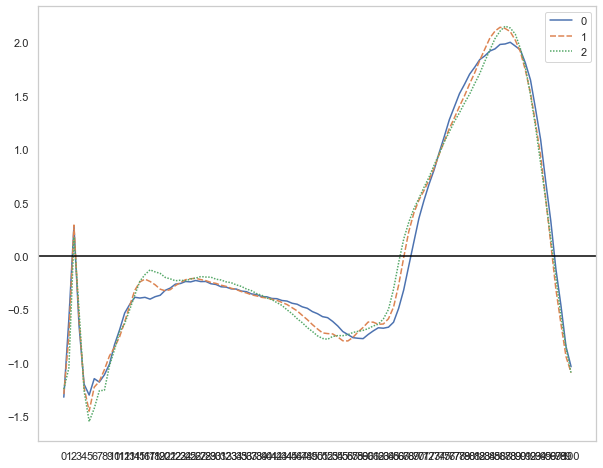

-------------------------
-------------------------
GYRx_taR_std:


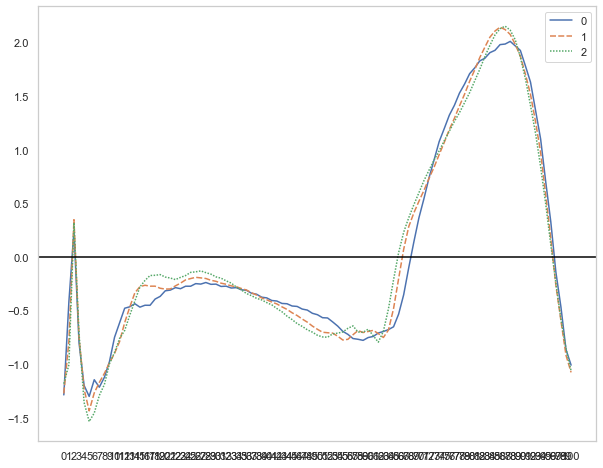

-------------------------
-------------------------
GYRx_tbL_std:


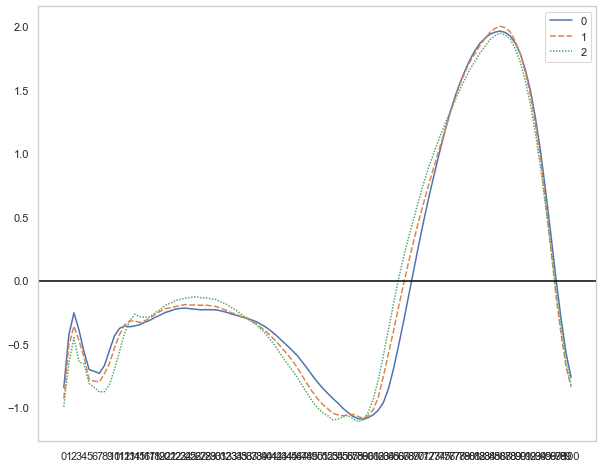

-------------------------
-------------------------
GYRx_tbR_std:


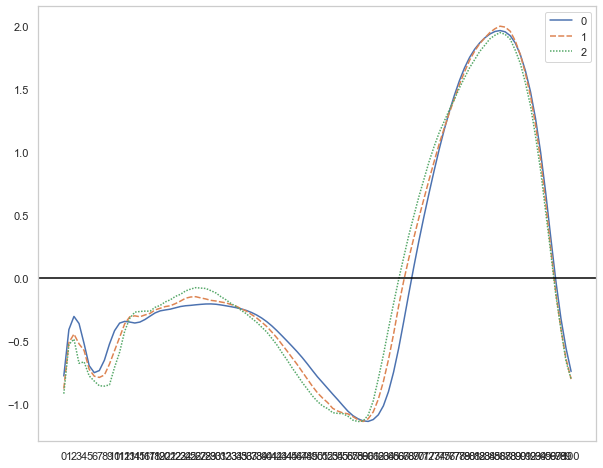

-------------------------
-------------------------
GYRy_taL_std:


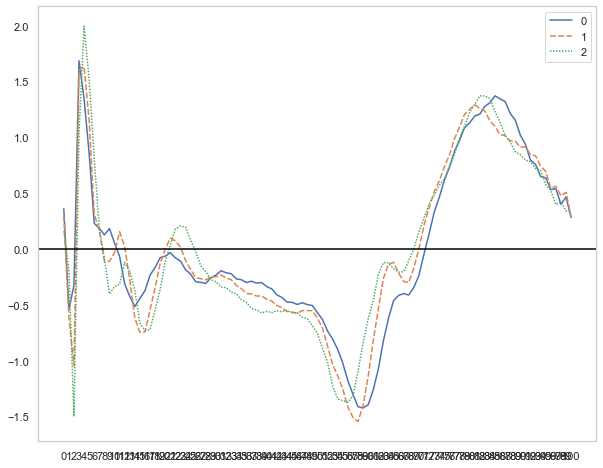

-------------------------
-------------------------
GYRy_taR_std:


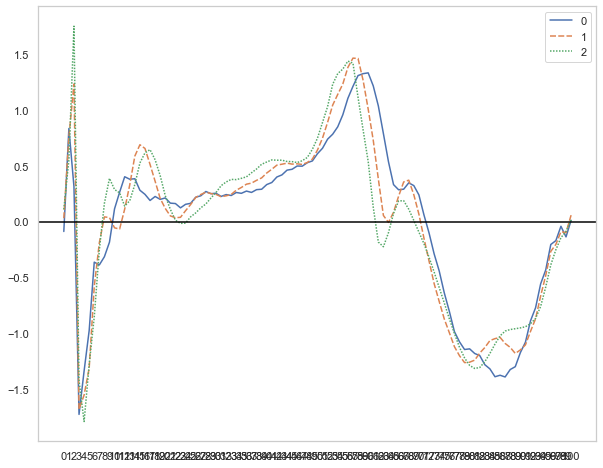

-------------------------
-------------------------
GYRy_tbL_std:


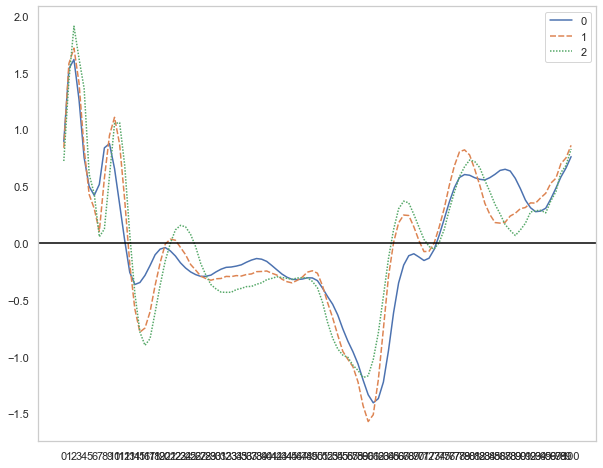

-------------------------
-------------------------
GYRy_tbR_std:


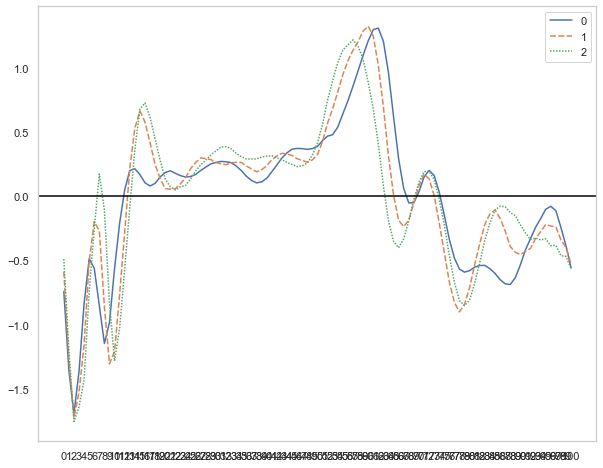

-------------------------
-------------------------
GYRz_taL_std:


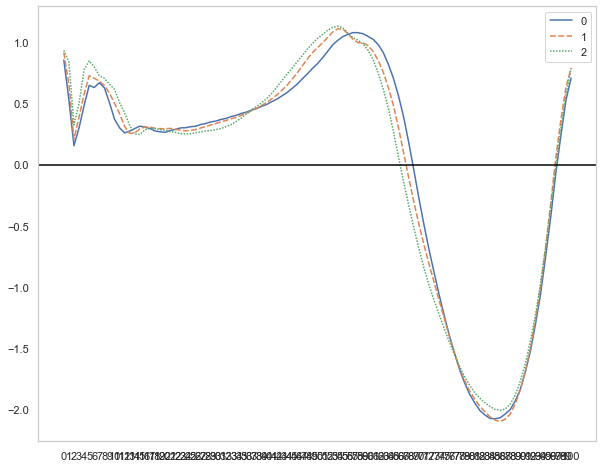

-------------------------
-------------------------
GYRz_taR_std:


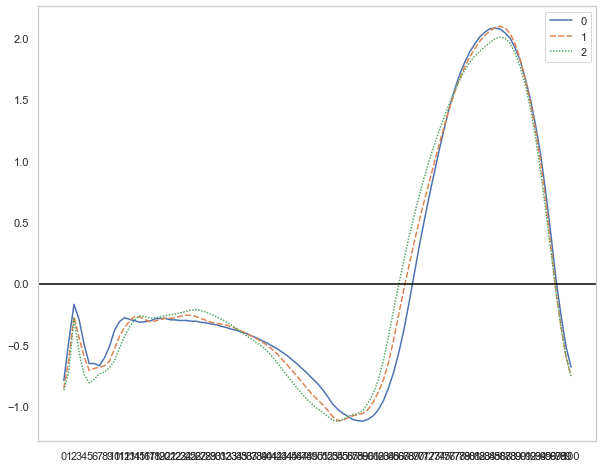

-------------------------
-------------------------
GYRz_tbL_std:


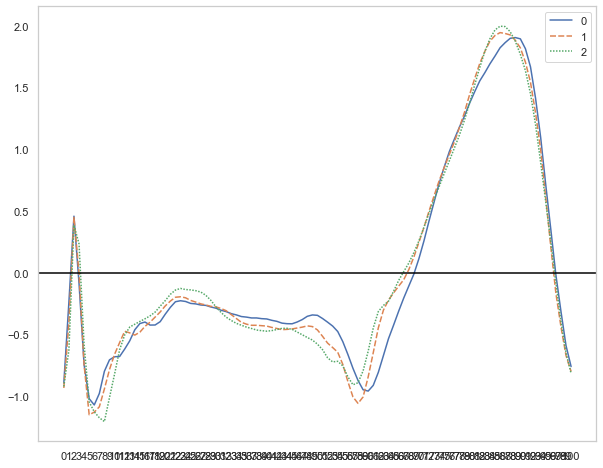

-------------------------
-------------------------
GYRz_tbR_std:


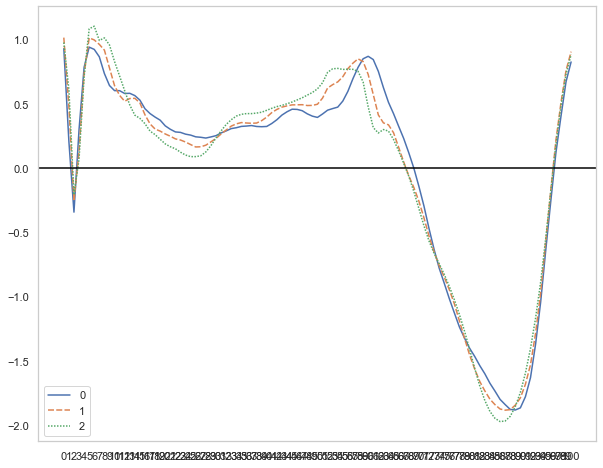

-------------------------


<Figure size 720x576 with 0 Axes>

In [522]:
#loop over each folder
for file_idx, file_name in enumerate(variable_matrices_folder):
    #load file
    file_path = os.path.join(os.getcwd()+'/strides/variable_matrices_strides_standard/'+file_name)
    variable_matrix = pd.read_csv(file_path,sep=',', index_col=0)
    #create a list of all speeds:
    all_speeds = ['s', 'c', 'f']
    
    #create an empty list to append
    variable_matrix_mean = []
    #loop over all unique values in subject_speed_trial list
    for speed in all_speeds:
        #calculate the mean of the selected values
        mean_vector = variable_matrix.loc[variable_matrix['speed'] == speed].drop(['subject_ID', 'trial', 'speed'], axis=1).mean()
        #append variable_matrix_mean list
        variable_matrix_mean.append(mean_vector)
    #convert list to data frame
    variable_matrix_mean_df = pd.DataFrame(variable_matrix_mean)
    #insert column of speeds back into matrix
    #variable_matrix_mean_df.insert(0, 'speed', all_speeds)
    print('-------------------------')
    print(file_name[:-4]+':')
    plot = sns.lineplot(data=variable_matrix_mean_df.transpose())
    plot.axhline(0, color='black')
    plt.show()
    plt.clf()
    print('-------------------------')

After a qualitative inspection of the graphs, it looks like the max, min, mean, and median could be some good features to calculate from each of the signals.

In [618]:
#create empty dataframe for storing statistical features
statistical_features = pd.DataFrame()

#loop over each folder
for file_idx, file_name in enumerate(variable_matrices_folder):
    #load file
    file_path = os.path.join(os.getcwd()+'/strides/variable_matrices_strides_standard/'+file_name)
    variable_matrix = pd.read_csv(file_path,sep=',', index_col=0)
    #drop the subject_ID, speed, and trial columns
    variable_matrix_values = variable_matrix.drop(['subject_ID', 'speed', 'trial'], axis=1)
    
    #calculate statistical values and insert into dataframe
    statistical_features.insert(0, ('max_'+file_name[:-8]), variable_matrix_values.max(axis=1).values)
    statistical_features.insert(0, ('min_'+file_name[:-8]), variable_matrix_values.min(axis=1).values)
    statistical_features.insert(0, ('mean_'+file_name[:-8]), variable_matrix_values.mean(axis=1).values)
    statistical_features.insert(0, ('median_'+file_name[:-8]), variable_matrix_values.median(axis=1).values)
    
#add the columns back to the dataframe
statistical_features.insert(0, 'subject_ID', variable_matrix['subject_ID'].values)
statistical_features.insert(1, 'speed', variable_matrix['speed'].values)
statistical_features.insert(2, 'trial', variable_matrix['trial'].values)
statistical_features.insert(3, 'subject_ID_speed', (variable_matrix['subject_ID'].values + variable_matrix['speed'].values))
    
#save statistical features to dataframe
pd.DataFrame.to_csv(statistical_features,os.getcwd()+'/strides/statistical_features/statistical_features.csv', sep=',', index=False)

Train ML model using statistical features and leave one out cross validation

In [619]:
#import data
statistical_features = pd.read_csv(os.getcwd()+'/statistical_features/statistical_features.csv',sep=',')

#convert speeds from strings to numbers
statistical_features = statistical_features.replace('s', 1)
statistical_features = statistical_features.replace('c', 2)
statistical_features = statistical_features.replace('f', 3)

#get list of all conditions
all_conditions = statistical_features['subject_ID'].unique()

#initialize lists to store accuracy and MSE
accuracy_list = []
mse_list = []


#loop over all conditions
for idx, condition in enumerate(all_conditions):
    
    #assign training data
    x_train = statistical_features.loc[statistical_features['subject_ID'] != condition].drop(['subject_ID', 'trial', 'subject_ID_speed', 'speed'], axis=1)
    y_train = statistical_features.loc[statistical_features['subject_ID'] != condition]['speed']

    #assign testing data
    x_test = statistical_features.loc[statistical_features['subject_ID'] == condition].drop(['subject_ID', 'trial', 'subject_ID_speed', 'speed'], axis=1)
    y_test = statistical_features.loc[statistical_features['subject_ID'] == condition]['speed']
    
    #standardize data
    sc = StandardScaler()
    sc.fit(x_train)
    x_train_std = sc.transform(x_train)
    x_test_std = sc.transform(x_test)
    
    #logistic regression classifier
    clf = LogisticRegression(max_iter=500)
    #clf = SVC()
    clf.fit(x_train_std, y_train)
    #generate prediction
    prediction = clf.predict(x_test_std)
    
    #calculate average accuracy and MSE
    accuracy_list.append(accuracy_score(y_test, prediction))
    mse_list.append(mean_squared_error(y_test, prediction))
    
    print('Crossfold '+str(idx)+' complete')
    print('Accuracy: ', accuracy_list[idx])
    print('MSE: ', mse_list[idx])
    print('--------------------------')


Crossfold 0 complete
Accuracy:  0.4371941272430669
MSE:  1.0277324632952691
--------------------------
Crossfold 1 complete
Accuracy:  0.41155234657039713
MSE:  1.2761732851985559
--------------------------
Crossfold 2 complete
Accuracy:  0.32075471698113206
MSE:  0.9811320754716981
--------------------------
Crossfold 3 complete
Accuracy:  0.666110183639399
MSE:  0.33889816360601
--------------------------
Crossfold 4 complete
Accuracy:  0.3463114754098361
MSE:  0.7889344262295082
--------------------------
Crossfold 5 complete
Accuracy:  0.8058455114822547
MSE:  0.25052192066805845
--------------------------
Crossfold 6 complete
Accuracy:  0.32781456953642385
MSE:  1.6009933774834437
--------------------------
Crossfold 7 complete
Accuracy:  0.3778409090909091
MSE:  1.2059659090909092
--------------------------
Crossfold 8 complete
Accuracy:  0.38078902229845624
MSE:  1.2727272727272727
--------------------------
Crossfold 9 complete
Accuracy:  0.40064620355411956
MSE:  1.23424878836

Calculate the average accuracy:

In [620]:
sum(accuracy_list)/len(accuracy_list)

0.47505235680241337

Using statistical features, we achieved an accuracy of 47% for classifying gait speed, which is lower compared to using principal components. I think that the sample size may be too large for the number of features, so we can try averaging over strides within each condition for each subject, which would bring the sample down to 396 (instead of ~12,000)

### 3) Using Signals as Features - all strides

Since there are multiple strides from each subject, leave one subject out cross validation will be used when training and testing the models. The training and testing data includes angular velocity signals as features.

In [622]:
#import data matrices 
RS_ML_matrix = pd.read_csv(os.getcwd()+'/ML_data/R_variables_all_std.csv', skiprows=0, index_col=0)
LS_ML_matrix = pd.read_csv(os.getcwd()+'/ML_data/L_variables_all_std.csv', skiprows=0, index_col=0)

In [623]:
#create a new column in each matrix that merges subject_id and speed for cross validation
RS_ML_matrix.insert(2, 'subject_ID_speed', (RS_ML_matrix['subject_ID'] + RS_ML_matrix['speed']))
LS_ML_matrix.insert(2, 'subject_ID_speed', (LS_ML_matrix['subject_ID'] + LS_ML_matrix['speed']))

In [624]:
#replace speed letters with numbers
#slow = s = 1
#controlled = c = 2
#fast = f = 3
RS_ML_matrix = RS_ML_matrix.replace('s', 1)
RS_ML_matrix = RS_ML_matrix.replace('c', 2)
RS_ML_matrix = RS_ML_matrix.replace('f', 3)
LS_ML_matrix = LS_ML_matrix.replace('s', 1)
LS_ML_matrix = LS_ML_matrix.replace('c', 2)
LS_ML_matrix = LS_ML_matrix.replace('f', 3)

In [627]:
#get list of all conditions
all_conditions = RS_ML_matrix['subject_ID'].unique()

#initialize lists to store accuracy and MSE
accuracy_list = []
mse_list = []


#loop over all conditions
for idx, condition in enumerate(all_conditions):
    
    #assign training data
    x_train = RS_ML_matrix.loc[RS_ML_matrix['subject_ID'] != condition].drop(['subject_ID', 'trial', 'subject_ID_speed', 'speed'], axis=1)
    y_train = RS_ML_matrix.loc[RS_ML_matrix['subject_ID'] != condition]['speed']

    #assign testing data
    x_test = RS_ML_matrix.loc[RS_ML_matrix['subject_ID'] == condition].drop(['subject_ID', 'trial', 'subject_ID_speed', 'speed'], axis=1)
    y_test = RS_ML_matrix.loc[RS_ML_matrix['subject_ID'] == condition]['speed']
    
    #standardize data
    #sc = StandardScaler()
    #sc.fit(x_train)
    #x_train_std = sc.transform(x_train)
    #x_test_std = sc.transform(x_test)
    
    #logistic regression classifier
    clf = LogisticRegression(max_iter=500)
    #clf = SVC()
    clf.fit(x_train, y_train)
    #generate prediction
    prediction = clf.predict(x_test)
    
    #calculate average accuracy and MSE
    accuracy_list.append(accuracy_score(y_test, prediction))
    mse_list.append(mean_squared_error(y_test, prediction))
    
    print('Crossfold '+str(idx)+' complete')
    print('Accuracy: ', accuracy_list[idx])
    print('MSE: ', mse_list[idx])
    print('--------------------------')


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 0 complete
Accuracy:  0.9086460032626428
MSE:  0.09624796084828711
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 1 complete
Accuracy:  0.7148014440433214
MSE:  0.33393501805054154
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 2 complete
Accuracy:  0.5513626834381551
MSE:  0.7756813417190775
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 3 complete
Accuracy:  0.7362270450751253
MSE:  0.2637729549248748
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 4 complete
Accuracy:  0.4016393442622951
MSE:  0.7151639344262295
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 5 complete
Accuracy:  0.7244258872651357
MSE:  0.2755741127348643
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 6 complete
Accuracy:  0.3973509933774834
MSE:  1.3923841059602649
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 7 complete
Accuracy:  0.3778409090909091
MSE:  1.0994318181818181
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 8 complete
Accuracy:  0.8970840480274442
MSE:  0.10291595197255575
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 9 complete
Accuracy:  0.8481421647819063
MSE:  0.1518578352180937
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 10 complete
Accuracy:  0.7606299212598425
MSE:  0.23937007874015748
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 11 complete
Accuracy:  0.4121475054229935
MSE:  0.8872017353579176
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 12 complete
Accuracy:  0.4638949671772429
MSE:  1.2385120350109409
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 13 complete
Accuracy:  0.4396887159533074
MSE:  0.566147859922179
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 14 complete
Accuracy:  0.7653239929947461
MSE:  0.23992994746059546
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 15 complete
Accuracy:  0.3503787878787879
MSE:  1.183712121212121
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 16 complete
Accuracy:  0.5550239234449761
MSE:  0.6650717703349283
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 17 complete
Accuracy:  0.7522281639928698
MSE:  0.33868092691622104
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 18 complete
Accuracy:  0.7274590163934426
MSE:  0.29713114754098363
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 19 complete
Accuracy:  0.8455598455598455
MSE:  0.1776061776061776
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 20 complete
Accuracy:  0.3204868154158215
MSE:  1.6105476673427992
--------------------------
Crossfold 21 complete
Accuracy:  0.5387523629489603
MSE:  0.6370510396975425
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Calculate the average accuracy:

In [628]:
sum(accuracy_list)/len(accuracy_list)

0.6131406609576024

Average accuracy over all crossfolds using leave one subject out cross validation = 62%

Using each stride and leave one out cross validation with feature sets as entire waveforms, principal compomnents, or statistical features doesn't work very well for classifying gait speed, which may be due to the large sample size and relatively small number of features (~12000 strides vs. anywhere from 23-600 features). An alternative approach would be to take the average of all signals across an entire trial, which would leave us with 6 representative signals for each subject at each speed. 

### 4) Ensemble average of all strides within a trial

Instead of using each strides as an observation, the following cells average across all strides for a single trial. There is one representative signal for each stride (396 trials = 22 subjects * 3 speeds * 6 trials)

The following cells concatenate the stride by stride data into trial by trial data:

In [635]:
#create directory
variable_matrices_folder = sorted(os.listdir(os.getcwd()+'/strides/variable_matrices_strides_standard'))
#remove .DS_Store file if it exists
if '.DS_Store' in variable_matrices_folder:
    variable_matrices_folder.remove('.DS_Store')

#loop over each folder
for file_idx, file_name in enumerate(variable_matrices_folder):
    #load file
    file_path = os.path.join(os.getcwd()+'/strides/variable_matrices_strides_standard/'+file_name)
    variable_matrix = pd.read_csv(file_path,sep=',', index_col=0)
    #convert trial from int to string
    variable_matrix = variable_matrix.astype({'trial':'string'})
    #insert a column for the subject_id, speed, and trial (example: s00c1)
    variable_matrix.insert(3, 'subject_speed_trial', (variable_matrix['subject_ID'] + variable_matrix['speed'] + variable_matrix['trial']))
    #create list of unique subject_speed_trial values
    all_conditions = variable_matrix['subject_speed_trial'].unique()
    
    #create an empty list to append
    variable_matrix_mean = []
    #loop over all unique values in subject_speed_trial list
    for condition in all_conditions:
        #calculate the mean of the selected values
        mean_vector = variable_matrix.loc[variable_matrix['subject_speed_trial'] == condition].drop(['subject_ID', 'trial', 'speed', 'subject_speed_trial'], axis=1).mean()
        #append variable_matrix_mean list
        variable_matrix_mean.append(mean_vector)
    #convert list to data frame
    variable_matrix_mean_df = pd.DataFrame(variable_matrix_mean)
    #insert list of all_conditions into dataframe
    variable_matrix_mean_df.insert(0, 'subject_speed_trial', all_conditions)
    #create columns for subject, speed, and trial
    variable_matrix_mean_df.insert(1, 'subject_ID', variable_matrix_mean_df['subject_speed_trial'].str[:3])
    variable_matrix_mean_df.insert(2, 'speed', variable_matrix_mean_df['subject_speed_trial'].str[3])
    variable_matrix_mean_df.insert(3, 'trial', variable_matrix_mean_df['subject_speed_trial'].str[4])
    
    
    pd.DataFrame.to_csv(variable_matrix_mean_df,os.getcwd()+'/trials/variable_matrices_trial_avgs/'+file_name, sep=',', index=False)
        
        

Concatenate all files for a limb into one file for ML modeling

In [636]:
#Right Shank

#create list of variables
variable_list = ['GYRx_taR_std', 'GYRy_taR_std', 'GYRz_taR_std', 'GYRx_tbR_std', 'GYRy_tbR_std', 'GYRz_tbR_std']
R_variables_all = pd.DataFrame()
#loop over variables in list
for i in variable_list:
    #load files
    current_file = pd.read_csv(os.getcwd()+'/trials/variable_matrices_trial_avgs/'+i+'.csv', index_col=0)
    #horizontally concatenate files
    R_variables_all = pd.concat([R_variables_all, current_file], axis=1)

    
#pop off repeated columns (subject_ID, trial, speed)
subject_ID = R_variables_all.pop('subject_ID').iloc[:,1]
speed = R_variables_all.pop('speed').iloc[:,1]
trial = R_variables_all.pop('trial').iloc[:,1]
#and reinsert one instance at beginning of dataframe
R_variables_all.insert(0, 'trial', trial)
R_variables_all.insert(0, 'speed', speed)
R_variables_all.insert(0, 'subject_ID', subject_ID)

#save file    
pd.DataFrame.to_csv(R_variables_all, os.getcwd()+'/trials/ML_data/R_variables_all_std.csv', sep=',')

In [638]:
#Left Shank

#create list of variables
variable_list = ['GYRx_taL_std', 'GYRy_taL_std', 'GYRz_taL_std', 'GYRx_tbL_std', 'GYRy_tbL_std', 'GYRz_tbL_std']
L_variables_all = pd.DataFrame()
#loop over variables in list
for i in variable_list:
    #load files
    current_file = pd.read_csv(os.getcwd()+'/trials/variable_matrices_trial_avgs/'+i+'.csv', index_col=0)
    #horizontally concatenate files
    L_variables_all = pd.concat([L_variables_all, current_file], axis=1)

    
#pop off repeated columns (subject_ID, trial, speed)
subject_ID = L_variables_all.pop('subject_ID').iloc[:,1]
speed = L_variables_all.pop('speed').iloc[:,1]
trial = L_variables_all.pop('trial').iloc[:,1]
#and reinsert one instance at beginning of dataframe
L_variables_all.insert(0, 'trial', trial)
L_variables_all.insert(0, 'speed', speed)
L_variables_all.insert(0, 'subject_ID', subject_ID)

#save file    
pd.DataFrame.to_csv(L_variables_all, os.getcwd()+'/trials/ML_data/L_variables_all_std.csv', sep=',')

Machine Learning modeling for the ensemble average of each stride within a trial.

In [643]:
#import data matrices 
RS_ML_matrix = pd.read_csv(os.getcwd()+'/trials/ML_data/R_variables_all_std.csv', skiprows=0)
LS_ML_matrix = pd.read_csv(os.getcwd()+'/trials/ML_data/L_variables_all_std.csv', skiprows=0)

#replace speed letters with numbers
#slow = s = 1
#controlled = c = 2
#fast = f = 3
RS_ML_matrix = RS_ML_matrix.replace('s', 1)
RS_ML_matrix = RS_ML_matrix.replace('c', 2)
RS_ML_matrix = RS_ML_matrix.replace('f', 3)
LS_ML_matrix = LS_ML_matrix.replace('s', 1)
LS_ML_matrix = LS_ML_matrix.replace('c', 2)
LS_ML_matrix = LS_ML_matrix.replace('f', 3)

#get list of all conditions
all_conditions = RS_ML_matrix['subject_ID'].unique()

#initialize lists to store accuracy and MSE
accuracy_list = []
mse_list = []


#loop over all conditions
for idx, condition in enumerate(all_conditions):
    
    #assign training data
    x_train = RS_ML_matrix.loc[RS_ML_matrix['subject_ID'] != condition].drop(['subject_ID', 'trial', 'subject_speed_trial', 'speed'], axis=1)
    y_train = RS_ML_matrix.loc[RS_ML_matrix['subject_ID'] != condition]['speed']

    #assign testing data
    x_test = RS_ML_matrix.loc[RS_ML_matrix['subject_ID'] == condition].drop(['subject_ID', 'trial', 'subject_speed_trial', 'speed'], axis=1)
    y_test = RS_ML_matrix.loc[RS_ML_matrix['subject_ID'] == condition]['speed']
    
    #standardize data
    #sc = StandardScaler()
    #sc.fit(x_train)
    #x_train_std = sc.transform(x_train)
    #x_test_std = sc.transform(x_test)
    
    #logistic regression classifier
    clf = LogisticRegression(max_iter=500)
    #clf = SVC()
    clf.fit(x_train, y_train)
    #generate prediction
    prediction = clf.predict(x_test)
    
    #calculate average accuracy and MSE
    accuracy_list.append(accuracy_score(y_test, prediction))
    mse_list.append(mean_squared_error(y_test, prediction))
    
    print('Crossfold '+str(idx)+' complete')
    print('Accuracy: ', accuracy_list[idx])
    print('MSE: ', mse_list[idx])
    print('--------------------------')


Crossfold 0 complete
Accuracy:  1.0
MSE:  0.0
--------------------------
Crossfold 1 complete
Accuracy:  1.0
MSE:  0.0
--------------------------
Crossfold 2 complete
Accuracy:  0.3333333333333333
MSE:  1.6666666666666667
--------------------------
Crossfold 3 complete
Accuracy:  0.5
MSE:  0.5
--------------------------
Crossfold 4 complete
Accuracy:  0.3333333333333333
MSE:  1.5
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 5 complete
Accuracy:  0.3333333333333333
MSE:  0.6666666666666666
--------------------------
Crossfold 6 complete
Accuracy:  0.6666666666666666
MSE:  0.3333333333333333
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 7 complete
Accuracy:  0.3333333333333333
MSE:  0.6666666666666666
--------------------------
Crossfold 8 complete
Accuracy:  0.3333333333333333
MSE:  1.6666666666666667
--------------------------
Crossfold 9 complete
Accuracy:  0.9444444444444444
MSE:  0.05555555555555555
--------------------------
Crossfold 10 complete
Accuracy:  1.0
MSE:  0.0
--------------------------
Crossfold 11 complete
Accuracy:  0.3333333333333333
MSE:  1.5
--------------------------
Crossfold 12 complete
Accuracy:  0.6666666666666666
MSE:  0.3333333333333333
--------------------------
Crossfold 13 complete
Accuracy:  0.6666666666666666
MSE:  0.3333333333333333
--------------------------
Crossfold 14 complete
Accuracy:  0.6666666666666666
MSE:  0.3333333333333333
--------------------------
Crossfold 15 complete
Accuracy:  0.3888888888888889
MSE:  1.4444444444444444
--------------------------
Crossfold 16 complete
Accuracy:  0.5555555555555556
MSE:  0.4444444444444444
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 17 complete
Accuracy:  0.4444444444444444
MSE:  0.5555555555555556
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 18 complete
Accuracy:  0.6666666666666666
MSE:  0.3333333333333333
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 19 complete
Accuracy:  0.8333333333333334
MSE:  0.16666666666666666
--------------------------


/Users/rossbrancati/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Crossfold 20 complete
Accuracy:  0.4444444444444444
MSE:  1.2222222222222223
--------------------------
Crossfold 21 complete
Accuracy:  0.3333333333333333
MSE:  0.6666666666666666
--------------------------


Calculate average accuracy:

In [644]:
sum(accuracy_list)/len(accuracy_list)

0.5808080808080809

### 5) Principal Components as Features - trial by trial data

In [693]:
#import data
RS_ML_matrix = pd.read_csv(os.getcwd()+'/trials/ML_data/R_variables_all_std.csv', sep=',')
LS_ML_matrix = pd.read_csv(os.getcwd()+'/trials/ML_data/L_variables_all_std.csv', sep=',')

#replace speed letters with numbers
#slow = s = 1
#controlled = c = 2
#fast = f = 3
RS_ML_matrix = RS_ML_matrix.replace('s', 1)
RS_ML_matrix = RS_ML_matrix.replace('c', 2)
RS_ML_matrix = RS_ML_matrix.replace('f', 3)
LS_ML_matrix = LS_ML_matrix.replace('s', 1)
LS_ML_matrix = LS_ML_matrix.replace('c', 2)
LS_ML_matrix = LS_ML_matrix.replace('f', 3)

In [694]:
leg_matrix = LS_ML_matrix
leg = 'L'

In [695]:
#initialize the principal component analysis
pca = PCA()

#fit_transform the data matrix (these are the PC scores)
scores = pca.fit_transform(X=leg_matrix.drop(['subject_ID', 'trial', 'subject_speed_trial', 'speed'], axis=1))
scores_df = pd.DataFrame(scores)
scores_df.insert(0, 'subject_ID', leg_matrix['subject_ID'].values)
scores_df.insert(1, 'speed', leg_matrix['speed'].values)
scores_df.insert(2, 'trial', leg_matrix['trial'].values)
scores_df.insert(3, 'subject_speed_trial', leg_matrix['subject_speed_trial'].values)


#export the scores
pd.DataFrame.to_csv(scores_df,os.getcwd()+'/trials/PCA_results/'+leg+'S_scores.csv', sep=',', index=False)

#get loadings (also referred to as eigenvectors or PCs)
loadings = pd.DataFrame(pca.components_)
#export the loadings
pd.DataFrame.to_csv(loadings,os.getcwd()+'/trials/PCA_results/'+leg+'S_loadings.csv', sep=',', index=False)

#get explained variance
explained_variance = pd.DataFrame(pca.explained_variance_ratio_.round(2))
#export the explaiend variance
pd.DataFrame.to_csv(explained_variance,os.getcwd()+'/trials/PCA_results/'+leg+'S_explained_variance.csv', sep=',', index=False)

We really only care about the principal components that explain variance in the data. Looking at the explained_variance dataframe, only the first 24 PCs explain a significant amount of variance. 

In [696]:
explained_variance.iloc[0:25]

,0
0,0.17
1,0.16
2,0.09
3,0.07
4,0.06
5,0.06
6,0.05
7,0.05
8,0.04
9,0.03


In [679]:
scores_df

,subject_ID,speed,subject_speed,0,1,2,3,4,5,6,...,56,57,58,59,60,61,62,63,64,65
0,s00,2,s00c,-1.827048,-0.192503,-0.023345,2.472756,-4.908676,2.863279,-0.732213,...,-0.210621,-0.093728,0.180650,0.069918,-0.053836,-0.004768,0.125664,-0.042568,-0.029864,2.259909e-15
1,s00,3,s00f,-1.567870,2.834744,1.109731,3.884278,-4.104195,4.016147,-1.780409,...,0.072749,-0.005346,-0.077954,-0.009388,0.039573,0.022747,-0.047890,-0.026908,-0.024819,2.259909e-15
2,s00,1,s00s,0.185501,-3.999152,2.061039,-1.124404,-1.763562,5.149057,-3.842236,...,0.106328,0.225368,0.047437,0.008913,0.085431,-0.004187,-0.053560,0.085613,0.018156,2.259909e-15
3,s01,2,s01c,-0.596427,0.860182,3.167065,-4.789144,-1.500866,-3.650238,-0.433759,...,0.345276,-0.129537,-0.429408,-0.134751,-0.416942,0.144278,-0.043470,0.075957,-0.111301,2.259909e-15
4,s01,3,s01f,-1.168550,3.935700,4.468955,-2.657531,-0.069994,-1.784308,0.256075,...,-0.080089,0.097817,0.143617,0.047964,0.161001,-0.031245,0.026377,0.005410,-0.056360,2.259909e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,s21,3,s21f,-2.076205,6.293117,-4.015207,-1.561581,2.562016,2.571791,5.180135,...,0.058246,0.030230,0.069427,0.019799,0.032759,0.067761,-0.039732,-0.029479,-0.034795,2.259909e-15
62,s21,1,s21s,-1.641013,-2.454981,-3.293870,3.473975,-0.602457,2.117702,1.893481,...,0.185320,0.015945,-0.073127,0.160799,-0.080153,0.140927,-0.148044,-0.061968,-0.004672,2.259909e-15
63,s22,2,s22c,1.232840,-5.568326,-1.341292,-5.557339,4.079169,-3.095375,-0.348754,...,0.070611,0.184998,-0.005016,-0.064799,0.031607,-0.009855,-0.104740,-0.032305,-0.004694,2.259909e-15
64,s22,3,s22f,-0.115816,-4.198258,-1.227538,-1.535263,1.780836,-4.288661,1.991009,...,-0.064217,-0.032177,-0.021159,0.069252,-0.033002,-0.017706,0.089779,0.003302,-0.002667,2.259909e-15


In [685]:
#get list of all conditions
all_conditions = scores_df['subject_ID'].unique()

#initialize lists to store accuracy and MSE
accuracy_list = []
mse_list = []

#loop over all conditions
for idx, condition in enumerate(all_conditions):
    
    #assign training data
    x_train = scores_df.loc[scores_df['subject_ID'] != condition].drop(['subject_ID', 'subject_speed', 'speed'], axis=1).iloc[:,0:24]
    y_train = scores_df.loc[scores_df['subject_ID'] != condition]['speed']

    #assign testing data
    x_test = scores_df.loc[scores_df['subject_ID'] == condition].drop(['subject_ID', 'subject_speed', 'speed'], axis=1).iloc[:,0:24]
    y_test = scores_df.loc[scores_df['subject_ID'] == condition]['speed']
    
    
    #standardize data
    sc = StandardScaler()
    sc.fit(x_train)
    x_train_std = sc.transform(x_train)
    x_test_std = sc.transform(x_test)
    
    #logistic regression classifier
    #clf = LogisticRegression(max_iter=500)
    clf = SVC()
    clf.fit(x_train, y_train)
    #generate prediction
    prediction = clf.predict(x_test)
    
    #calculate average accuracy and MSE
    accuracy_list.append(accuracy_score(y_test, prediction))
    mse_list.append(mean_squared_error(y_test, prediction))
    
    print('Crossfold '+str(idx)+' complete')
    print('Accuracy: ', accuracy_list[idx])
    print('MSE: ', mse_list[idx])
    print('--------------------------')

Crossfold 0 complete
Accuracy:  1.0
MSE:  0.0
--------------------------
Crossfold 1 complete
Accuracy:  0.6666666666666666
MSE:  0.3333333333333333
--------------------------
Crossfold 2 complete
Accuracy:  0.3333333333333333
MSE:  1.6666666666666667
--------------------------
Crossfold 3 complete
Accuracy:  0.3333333333333333
MSE:  0.6666666666666666
--------------------------
Crossfold 4 complete
Accuracy:  0.3333333333333333
MSE:  1.6666666666666667
--------------------------
Crossfold 5 complete
Accuracy:  1.0
MSE:  0.0
--------------------------
Crossfold 6 complete
Accuracy:  0.3333333333333333
MSE:  0.6666666666666666
--------------------------
Crossfold 7 complete
Accuracy:  0.3333333333333333
MSE:  0.6666666666666666
--------------------------
Crossfold 8 complete
Accuracy:  1.0
MSE:  0.0
--------------------------
Crossfold 9 complete
Accuracy:  1.0
MSE:  0.0
--------------------------
Crossfold 10 complete
Accuracy:  1.0
MSE:  0.0
--------------------------
Crossfold 11 com

In [686]:
sum(accuracy_list)/len(accuracy_list)

0.6060606060606062

SVM achieved an accuracy of about 61%. The following cell concatenates the PC scores from the left and right shanks into one file.

In [705]:
#concatenate scores from right and left shanks into one dataframe
RS_PC_scores = pd.read_csv(os.getcwd()+'/trials/PCA_results/RS_scores.csv', sep=',')
LS_PC_scores = pd.read_csv(os.getcwd()+'/trials/PCA_results/LS_scores.csv', sep=',')
#concatenate
all_scores = pd.concat([RS_PC_scores.drop(['subject_ID', 'trial', 'subject_speed_trial', 'speed'], axis=1).iloc[:,0:25],
                      LS_PC_scores.drop(['subject_ID', 'trial', 'subject_speed_trial', 'speed'], axis=1).iloc[:,0:25]], axis=1)
#re-insert labels at front of dataframe
all_scores.insert(0, 'subject_ID', RS_PC_scores['subject_ID'].values)
all_scores.insert(1, 'speed', RS_PC_scores['speed'].values)
all_scores.insert(2, 'trial', RS_PC_scores['trial'].values)
all_scores.insert(3, 'subject_speed_trial', RS_PC_scores['subject_speed_trial'].values)
#save
pd.DataFrame.to_csv(all_scores, os.getcwd()+'/trials/PCA_results/all_scores.csv', sep=',', index=False)

### 6) Ensemble average of all strides (and trials)

In [665]:
#create directory
variable_matrices_folder = sorted(os.listdir(os.getcwd()+'/trials/variable_matrices_trial_avgs'))
#remove .DS_Store file if it exists
if '.DS_Store' in variable_matrices_folder:
    variable_matrices_folder.remove('.DS_Store')

#loop over each folder
for file_idx, file_name in enumerate(variable_matrices_folder):
    #load file
    file_path = os.path.join(os.getcwd()+'/trials/variable_matrices_trial_avgs/'+file_name)
    variable_matrix = pd.read_csv(file_path,sep=',', index_col=0)
    #convert trial from int to string
    variable_matrix = variable_matrix.astype({'trial':'string'})
    #insert a column for the subject_id, speed, and trial (example: s00c1)
    variable_matrix.insert(3, 'subject_speed', (variable_matrix['subject_ID'] + variable_matrix['speed']))
    #create list of unique subject_speed_trial values
    all_conditions = variable_matrix['subject_speed'].unique()
    
    #create an empty list to append
    variable_matrix_mean = []
    #loop over all unique values in subject_speed_trial list
    for condition in all_conditions:
        #calculate the mean of the selected values
        mean_vector = variable_matrix.loc[variable_matrix['subject_speed'] == condition].drop(['subject_ID', 'trial', 'speed', 'subject_speed'], axis=1).mean()
        #append variable_matrix_mean list
        variable_matrix_mean.append(mean_vector)
    #convert list to data frame
    variable_matrix_mean_df = pd.DataFrame(variable_matrix_mean)
    #insert list of all_conditions into dataframe
    variable_matrix_mean_df.insert(0, 'subject_speed', all_conditions)
    #create columns for subject, speed, and trial
    variable_matrix_mean_df.insert(1, 'subject_ID', variable_matrix_mean_df['subject_speed'].str[:3])
    variable_matrix_mean_df.insert(2, 'speed', variable_matrix_mean_df['subject_speed'].str[3])
    
    
    pd.DataFrame.to_csv(variable_matrix_mean_df,os.getcwd()+'/conditions/variable_matrices_condition_avgs/'+file_name, sep=',', index=False)
    
    

Concatenate all files for a limb into one file for ML modeling

In [667]:
#Right Shank

#create list of variables
variable_list = ['GYRx_taR_std', 'GYRy_taR_std', 'GYRz_taR_std', 'GYRx_tbR_std', 'GYRy_tbR_std', 'GYRz_tbR_std']
R_variables_all = pd.DataFrame()
#loop over variables in list
for i in variable_list:
    #load files
    current_file = pd.read_csv(os.getcwd()+'/conditions/variable_matrices_condition_avgs/'+i+'.csv', index_col=0)
    #horizontally concatenate files
    R_variables_all = pd.concat([R_variables_all, current_file], axis=1)

    
#pop off repeated columns (subject_ID, trial, speed)
subject_ID = R_variables_all.pop('subject_ID').iloc[:,1]
speed = R_variables_all.pop('speed').iloc[:,1]
#and reinsert one instance at beginning of dataframe
R_variables_all.insert(0, 'speed', speed)
R_variables_all.insert(0, 'subject_ID', subject_ID)

#save file    
pd.DataFrame.to_csv(R_variables_all, os.getcwd()+'/conditions/ML_data/R_variables_all_std.csv', sep=',')

In [668]:
#Left Shank

#create list of variables
variable_list = ['GYRx_taL_std', 'GYRy_taL_std', 'GYRz_taL_std', 'GYRx_tbL_std', 'GYRy_tbL_std', 'GYRz_tbL_std']
L_variables_all = pd.DataFrame()
#loop over variables in list
for i in variable_list:
    #load files
    current_file = pd.read_csv(os.getcwd()+'/conditions/variable_matrices_condition_avgs/'+i+'.csv', index_col=0)
    #horizontally concatenate files
    L_variables_all = pd.concat([L_variables_all, current_file], axis=1)

    
#pop off repeated columns (subject_ID, trial, speed)
subject_ID = L_variables_all.pop('subject_ID').iloc[:,1]
speed = L_variables_all.pop('speed').iloc[:,1]
#and reinsert one instance at beginning of dataframe
L_variables_all.insert(0, 'speed', speed)
L_variables_all.insert(0, 'subject_ID', subject_ID)

#save file    
pd.DataFrame.to_csv(L_variables_all, os.getcwd()+'/conditions/ML_data/L_variables_all_std.csv', sep=',')

Now we have a matrix with 66 observations, but ~600 features. The feature to observation ratio is around 10, which is way too large. Instead of using raw signals, lets try extracting the principal components to reduce the dimensionality while still retaining most of the information in the signals. 

### 7) Principal Components as features - ensemble average of all strides and all trials

In [687]:
#import data
RS_ML_matrix = pd.read_csv(os.getcwd()+'/conditions/ML_data/R_variables_all_std.csv', sep=',')
LS_ML_matrix = pd.read_csv(os.getcwd()+'/conditions/ML_data/L_variables_all_std.csv', sep=',')

#replace speed letters with numbers
#slow = s = 1
#controlled = c = 2
#fast = f = 3
RS_ML_matrix = RS_ML_matrix.replace('s', 1)
RS_ML_matrix = RS_ML_matrix.replace('c', 2)
RS_ML_matrix = RS_ML_matrix.replace('f', 3)
LS_ML_matrix = LS_ML_matrix.replace('s', 1)
LS_ML_matrix = LS_ML_matrix.replace('c', 2)
LS_ML_matrix = LS_ML_matrix.replace('f', 3)


In [688]:
#initialize the principal component analysis
pca = PCA()

#fit_transform the data matrix (these are the PC scores)
scores = pca.fit_transform(X=LS_ML_matrix.drop(['subject_ID', 'subject_speed', 'speed'], axis=1))
scores_df = pd.DataFrame(scores)
scores_df.insert(0, 'subject_ID', LS_ML_matrix['subject_ID'].values)
scores_df.insert(1, 'speed', LS_ML_matrix['speed'].values)
scores_df.insert(2, 'subject_speed', LS_ML_matrix['subject_speed'].values)


#export the scores
pd.DataFrame.to_csv(scores_df,os.getcwd()+'/conditions/PCA_results/LS_scores.csv', sep=',', index=False)

#get loadings (also referred to as eigenvectors or PCs)
loadings = pd.DataFrame(pca.components_)
#export the loadings
pd.DataFrame.to_csv(loadings,os.getcwd()+'/conditions/PCA_results/LS_loadings.csv', sep=',', index=False)

#get explained variance
explained_variance = pd.DataFrame(pca.explained_variance_ratio_.round(2))
#export the explaiend variance
pd.DataFrame.to_csv(explained_variance,os.getcwd()+'/conditions/PCA_results/LS_explained_variance.csv', sep=',', index=False)

We really only care about the principal components that explain variance in the data. Looking at the explained_variance dataframe, only the first 23 PCs explain a significant amount of variance. 

In [672]:
explained_variance.iloc[0:25]

,0
0,0.17
1,0.14
2,0.11
3,0.08
4,0.06
5,0.06
6,0.05
7,0.04
8,0.04
9,0.03


In [673]:
scores_df

,subject_ID,speed,subject_speed,0,1,2,3,4,5,6,...,56,57,58,59,60,61,62,63,64,65
0,s00,2,s00c,-1.827048,-0.192503,-0.023345,2.472756,-4.908676,2.863279,-0.732213,...,-0.210621,-0.093728,0.180650,0.069918,-0.053836,-0.004768,0.125664,-0.042568,-0.029864,2.259909e-15
1,s00,3,s00f,-1.567870,2.834744,1.109731,3.884278,-4.104195,4.016147,-1.780409,...,0.072749,-0.005346,-0.077954,-0.009388,0.039573,0.022747,-0.047890,-0.026908,-0.024819,2.259909e-15
2,s00,1,s00s,0.185501,-3.999152,2.061039,-1.124404,-1.763562,5.149057,-3.842236,...,0.106328,0.225368,0.047437,0.008913,0.085431,-0.004187,-0.053560,0.085613,0.018156,2.259909e-15
3,s01,2,s01c,-0.596427,0.860182,3.167065,-4.789144,-1.500866,-3.650238,-0.433759,...,0.345276,-0.129537,-0.429408,-0.134751,-0.416942,0.144278,-0.043470,0.075957,-0.111301,2.259909e-15
4,s01,3,s01f,-1.168550,3.935700,4.468955,-2.657531,-0.069994,-1.784308,0.256075,...,-0.080089,0.097817,0.143617,0.047964,0.161001,-0.031245,0.026377,0.005410,-0.056360,2.259909e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,s21,3,s21f,-2.076205,6.293117,-4.015207,-1.561581,2.562016,2.571791,5.180135,...,0.058246,0.030230,0.069427,0.019799,0.032759,0.067761,-0.039732,-0.029479,-0.034795,2.259909e-15
62,s21,1,s21s,-1.641013,-2.454981,-3.293870,3.473975,-0.602457,2.117702,1.893481,...,0.185320,0.015945,-0.073127,0.160799,-0.080153,0.140927,-0.148044,-0.061968,-0.004672,2.259909e-15
63,s22,2,s22c,1.232840,-5.568326,-1.341292,-5.557339,4.079169,-3.095375,-0.348754,...,0.070611,0.184998,-0.005016,-0.064799,0.031607,-0.009855,-0.104740,-0.032305,-0.004694,2.259909e-15
64,s22,3,s22f,-0.115816,-4.198258,-1.227538,-1.535263,1.780836,-4.288661,1.991009,...,-0.064217,-0.032177,-0.021159,0.069252,-0.033002,-0.017706,0.089779,0.003302,-0.002667,2.259909e-15


In [657]:
#get list of all conditions
all_conditions = scores_df['subject_ID'].unique()

#initialize lists to store accuracy and MSE
accuracy_list = []
mse_list = []

#loop over all conditions
for idx, condition in enumerate(all_conditions):
    
    #assign training data
    x_train = scores_df.loc[scores_df['subject_ID'] != condition].drop(['subject_ID', 'trial', 'subject_speed_trial', 'speed'], axis=1).iloc[:,0:23]
    y_train = scores_df.loc[scores_df['subject_ID'] != condition]['speed']

    #assign testing data
    x_test = scores_df.loc[scores_df['subject_ID'] == condition].drop(['subject_ID', 'trial', 'subject_speed_trial', 'speed'], axis=1).iloc[:,0:23]
    y_test = scores_df.loc[scores_df['subject_ID'] == condition]['speed']
    
    
    #standardize data
    sc = StandardScaler()
    sc.fit(x_train)
    x_train_std = sc.transform(x_train)
    x_test_std = sc.transform(x_test)
    
    #logistic regression classifier
    #clf = LogisticRegression(max_iter=500)
    clf = SVC()
    clf.fit(x_train, y_train)
    #generate prediction
    prediction = clf.predict(x_test)
    
    #calculate average accuracy and MSE
    accuracy_list.append(accuracy_score(y_test, prediction))
    mse_list.append(mean_squared_error(y_test, prediction))
    
    print('Crossfold '+str(idx)+' complete')
    print('Accuracy: ', accuracy_list[idx])
    print('MSE: ', mse_list[idx])
    print('--------------------------')

Crossfold 0 complete
Accuracy:  1.0
MSE:  0.0
--------------------------
Crossfold 1 complete
Accuracy:  0.8888888888888888
MSE:  0.1111111111111111
--------------------------
Crossfold 2 complete
Accuracy:  0.3333333333333333
MSE:  1.0
--------------------------
Crossfold 3 complete
Accuracy:  0.7222222222222222
MSE:  0.2777777777777778
--------------------------
Crossfold 4 complete
Accuracy:  0.3333333333333333
MSE:  0.6666666666666666
--------------------------
Crossfold 5 complete
Accuracy:  0.6666666666666666
MSE:  0.3333333333333333
--------------------------
Crossfold 6 complete
Accuracy:  0.3333333333333333
MSE:  0.6666666666666666
--------------------------
Crossfold 7 complete
Accuracy:  0.3333333333333333
MSE:  0.6666666666666666
--------------------------
Crossfold 8 complete
Accuracy:  0.3888888888888889
MSE:  0.6111111111111112
--------------------------
Crossfold 9 complete
Accuracy:  1.0
MSE:  0.0
--------------------------
Crossfold 10 complete
Accuracy:  1.0
MSE:  0.

Calculate the average accuracy:

In [658]:
sum(accuracy_list)/len(accuracy_list)

0.5883838383838385

Using the principal components, we achieved an accuracy of 48% for classifying gait speed with a logistic regresssion model. The training speed was much faster, but the accuracy is still very low. Also tried a support vector machine which boosted the accuracy to 58%. One final approach would be to average all of the trials together, which will bring the sample down to 66 (22 subjects * 3 gait speeds). 

# Part 3: Deep Learning

Deep learning is great for time series data because we don't need to engineer features to represent the time-series data. Instead of using principal components or statistical features of the time series signals, we can feed the signals directly into a neural network and it will extract features of the data that are optimal for classifying the dataset. With a large number of features and samples, the deep learning approach outperformed both logistic regression and SVMs.<br>

The input data is the IMU signals of the right shank only. <br>

#### Step 1: Importing data and testing deep learning framework

In [973]:
#import data
data = pd.read_csv(os.getcwd()+'/strides/ML_data/R_variables_all_std.csv', sep=',', index_col=0)
data

,subject_ID,speed,trial,0,1,2,3,4,5,6,...,91.5,92.5,93.5,94.5,95.5,96.5,97.5,98.5,99.5,100.5
0,s00,c,1,-0.785499,0.048891,0.887749,-1.538448,-1.498763,-1.410166,-0.755886,...,-2.145579,-2.024937,-1.742317,-1.431725,-1.008357,-0.604923,-0.200607,0.109992,0.435033,0.512502
1,s00,c,1,-0.515080,0.186497,-0.137469,-1.348494,-1.103039,-1.753461,-0.907637,...,-2.279677,-2.288844,-2.218154,-2.053697,-1.721983,-1.363308,-0.914097,-0.491090,-0.109573,0.170197
2,s00,c,1,-0.466326,0.008363,-1.091427,-0.984386,-0.692273,-1.275159,-1.092490,...,-2.037255,-1.745499,-1.345704,-0.917662,-0.529495,-0.130319,0.190606,0.430144,0.565811,0.613459
3,s00,c,1,-0.748953,-0.001351,-0.078294,-1.676746,-1.504785,-1.525641,-0.497352,...,-2.406615,-2.299132,-2.109052,-1.845726,-1.441080,-1.010931,-0.548103,-0.129683,0.194304,0.456805
4,s00,c,1,-0.721953,0.351601,-0.187786,-1.395962,-1.289673,-1.824039,-0.796538,...,-2.253681,-2.125113,-1.888527,-1.550835,-1.111220,-0.669228,-0.214431,0.221778,0.508470,0.793325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,s22,s,6,-0.867486,0.431548,-0.170909,-1.310338,-1.955833,-2.225970,-1.816291,...,-1.580561,-0.729205,0.184986,0.711433,0.808552,0.510799,0.502856,0.630475,1.096373,1.175347
29,s22,s,6,-0.793640,0.247581,-0.642847,-1.456182,-1.824447,-1.978281,-1.783781,...,-3.016800,-2.433813,-1.366641,-0.145324,0.587915,0.631695,0.630369,0.625611,0.925510,1.033270
30,s22,s,6,-0.821355,0.569941,-0.334288,-1.263533,-1.660690,-1.896455,-2.131514,...,-3.750511,-3.434145,-2.316985,-0.825054,0.702685,1.171039,1.098561,0.792446,0.870793,0.931981
31,s22,s,6,-0.768815,0.594295,-0.188425,-1.111532,-1.500936,-1.686423,-1.908461,...,-2.444916,-2.133775,-1.497435,-0.597643,0.213426,0.566586,0.556478,0.510004,0.757065,1.063219


In [974]:
x_train = data.loc[data['subject_ID'] != 's00'].drop(['subject_ID', 'speed', 'trial'], axis=1)
x_test = data.loc[data['subject_ID'] == 's00'].drop(['subject_ID', 'trial', 'speed'], axis=1)
y_train = data.loc[data['subject_ID'] != 's00']['speed']
y_test = data.loc[data['subject_ID'] == 's00']['speed']

Reshape data like: X_train.reshape(num_of_examples, num_of_features, num_of_signals) See https://stackoverflow.com/questions/50005092/how-to-build-1d-convolutional-neural-network-in-keras-python

In [975]:
X_train = np.asarray(x_train)
X_train = X_train.reshape(X_train.shape[0], 101, 6)

In [976]:
X_test = np.asarray(x_test)
X_test = X_test.reshape(X_test.shape[0], 101, 6)

In [977]:
encoder = LabelEncoder()
encoder.fit(y_train.values)

y_train = encoder.transform(y_train.values)
y_test = encoder.transform(y_test.values)

#Convert y_train and y_test to categorical variables 
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [978]:
#display shapes of training and testing data to confirm that dimensions match
print("X train:", X_train.shape)
print("Y train:", y_train.shape)
print("----------------------------")
print("X test:", X_test.shape)
print("Y test:", y_test.shape)

X train: (11489, 101, 6)
Y train: (11489, 3)
----------------------------
X test: (613, 101, 6)
Y test: (613, 3)


In [979]:
len(encoder.classes_)

3

In [936]:
#create deep learning architecture

model = Sequential()
#since we only have a 1D vector, only 1D convolutional layers are needed
model.add(Conv1D(filters=16, kernel_size=2, input_shape=(101, 6)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(GlobalAveragePooling1D())

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 100, 16)           208       
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 50, 16)            0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 49, 32)            1056      
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 24, 32)            0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 24, 32)            0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 23, 64)            4160      
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 11, 64)          

In [937]:
#compile model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(lr = 0.001))

In [946]:
#test neural network
history = model.fit(X_train, y_train, batch_size=64, epochs=200, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/200
180/180 [==============================] - 2s 12ms/step - loss: 0.1125 - accuracy: 0.9566 - val_loss: 0.2522 - val_accuracy: 0.8940
Epoch 2/200
180/180 [==============================] - 2s 12ms/step - loss: 0.1113 - accuracy: 0.9573 - val_loss: 0.2440 - val_accuracy: 0.8972
Epoch 3/200
180/180 [==============================] - 2s 11ms/step - loss: 0.1092 - accuracy: 0.9589 - val_loss: 0.2182 - val_accuracy: 0.8989
Epoch 4/200
180/180 [==============================] - 2s 11ms/step - loss: 0.1179 - accuracy: 0.9544 - val_loss: 0.2566 - val_accuracy: 0.8858
Epoch 5/200
180/180 [==============================] - 2s 11ms/step - loss: 0.1180 - accuracy: 0.9533 - val_loss: 0.2712 - val_accuracy: 0.8858
Epoch 6/200
 81/180 [============>.................] - ETA: 1s - loss: 0.1214 - accuracy: 0.9554

KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

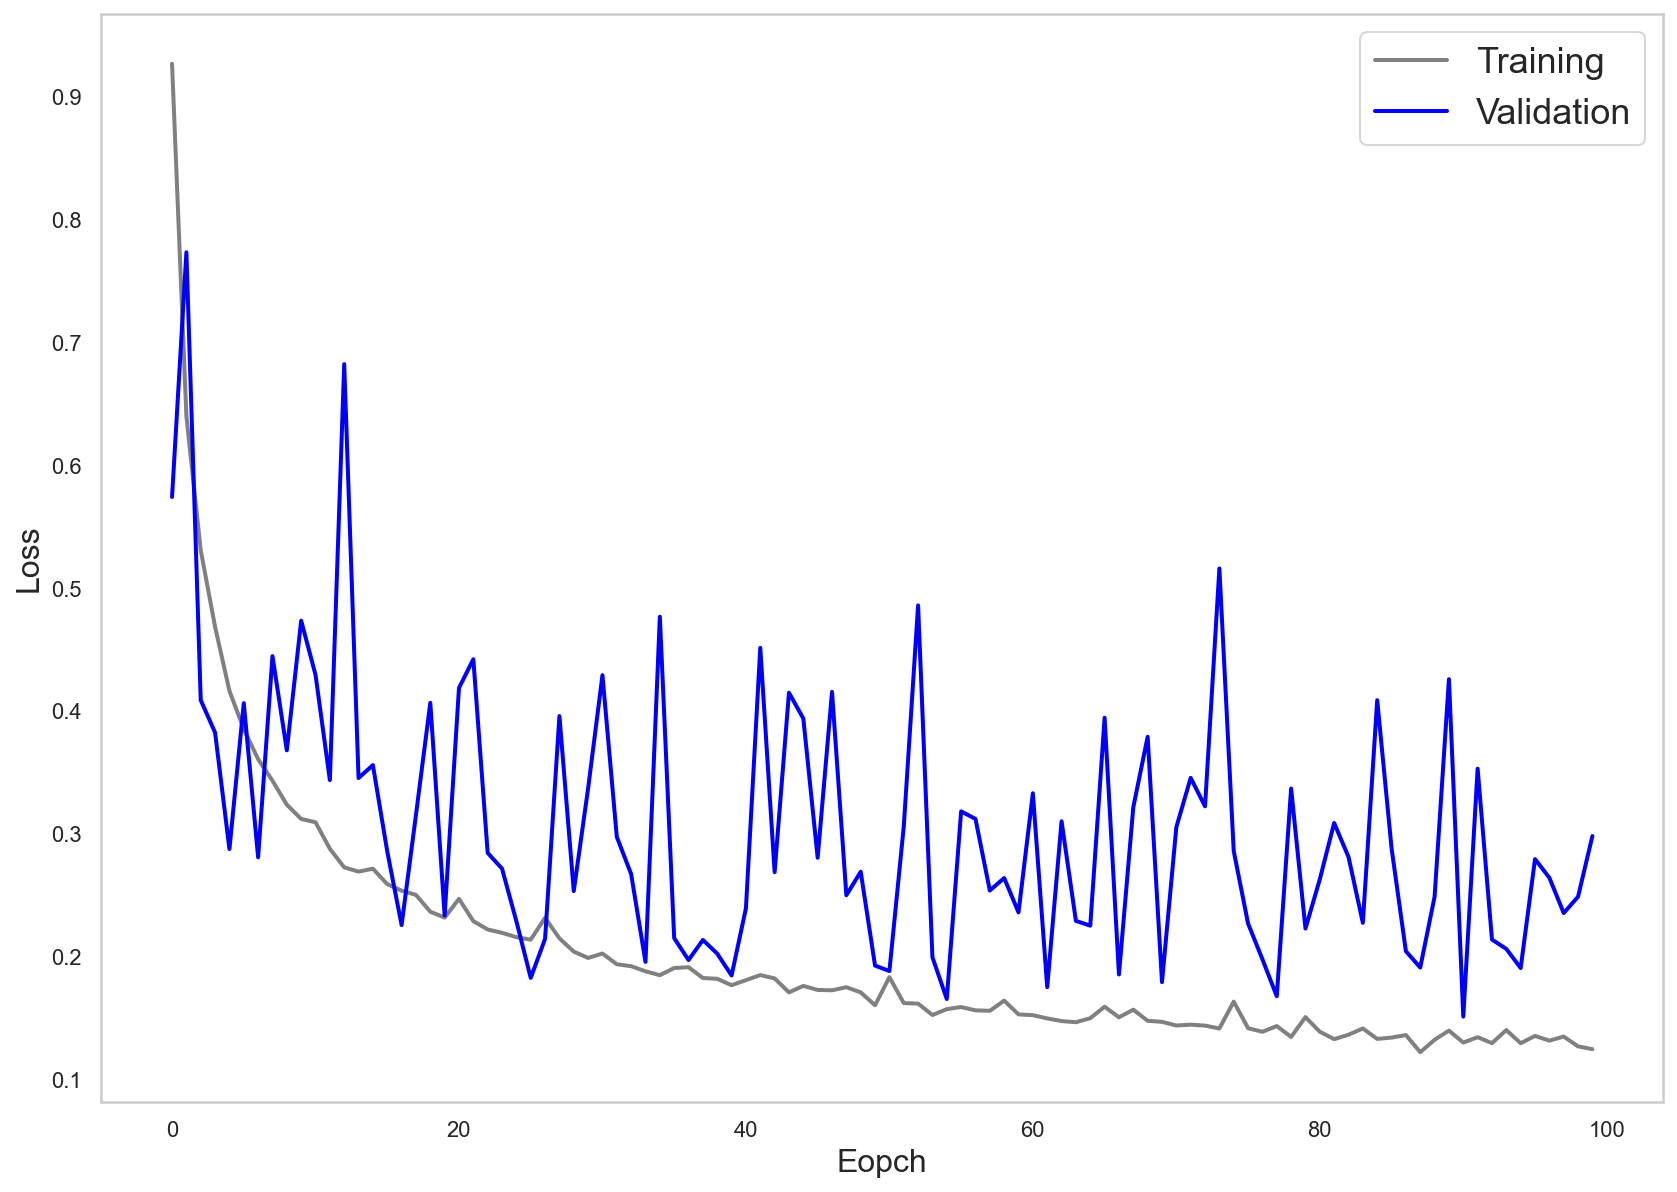

In [939]:
plt.figure(figsize=[14,10])
plt.plot(history.history['loss'], 'gray', linewidth=2.0)
plt.plot(history.history['val_loss'], 'blue', linewidth=2.0)
plt.legend(['Training', 'Validation'],fontsize=18)
plt.xlabel('Eopch',fontsize=16)
plt.ylabel('Loss',fontsize=16)

Text(0, 0.5, 'Loss')

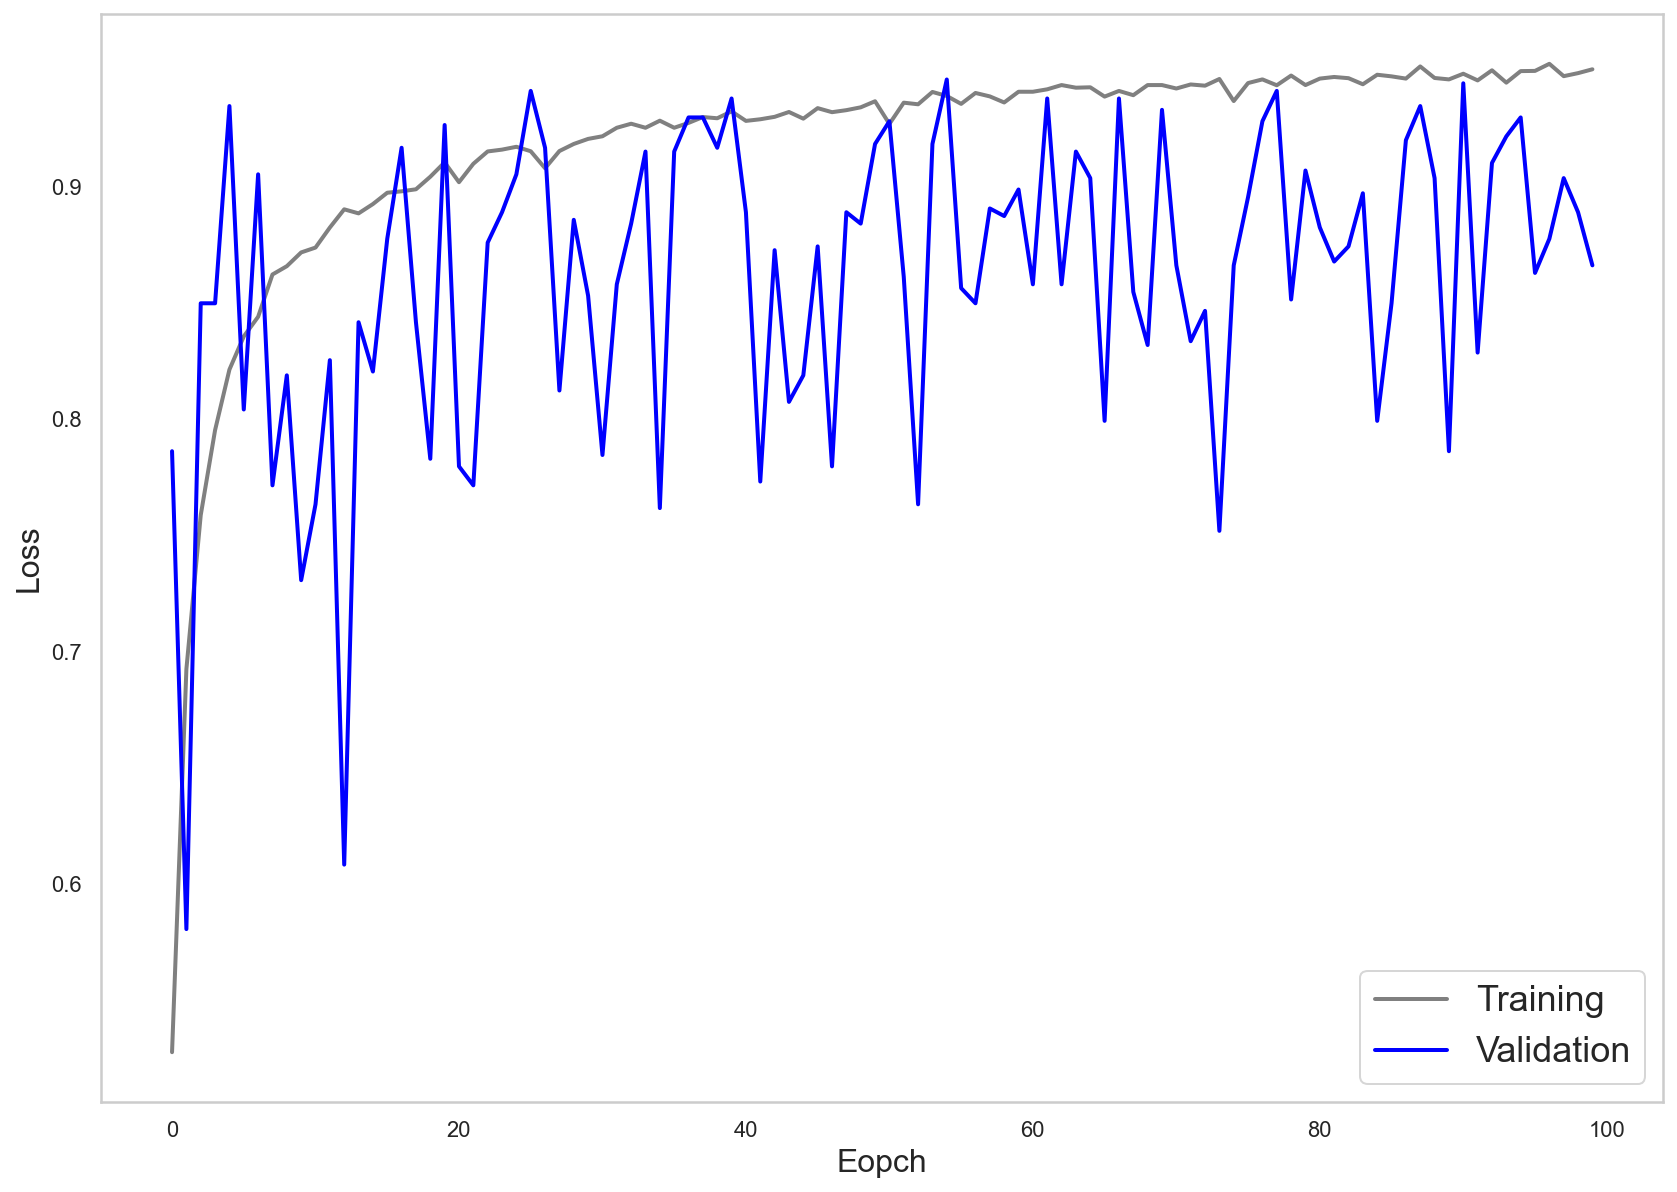

In [940]:
plt.figure(figsize=[14,10])
plt.plot(history.history['accuracy'], 'gray', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training', 'Validation'],fontsize=18)
plt.xlabel('Eopch',fontsize=16)
plt.ylabel('Loss',fontsize=16)

#### Step 2: Fitting Deep Learning Model with Leave One Subject Out Cross Validation

Once the deep learning model is tested on a simple split between training and testing data, we can now move towards the leave one subject out cross validation approach. <br>

I imported this section of the notebook into Google Colab so I could train the network with their GPU for better efficiency. See the other notebook in the repository titled IMU_gait_speed_classification_google_colab.ipynb for a compiled notebook.

In [972]:
#deep learning architecture

model = Sequential()
#since we only have a 1D vector, only 1D convolutional layers are needed
model.add(Conv1D(filters=16, kernel_size=2, input_shape=(101, 6)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(GlobalAveragePooling1D())

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_38 (Conv1D)           (None, 100, 16)           208       
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 50, 16)            0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 49, 32)            1056      
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 24, 32)            0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 24, 32)            0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 23, 64)            4160      
_________________________________________________________________
max_pooling1d_39 (MaxPooling (None, 11, 64)          

In [966]:
#compile model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(lr = 0.001))

In [967]:
#import data
data = pd.read_csv(os.getcwd()+'/strides/ML_data/R_variables_all_std.csv', sep=',', index_col=0)

In [971]:
#get a list of all subjects
all_subjects = data['subject_ID'].unique()

#create an empty list to store accuracy in
max_accuracy_list = []
average_accuracy_list = []
average_accuracy_list_third = []

#loop over all conditions
for idx, subject_ID in enumerate(all_subjects):
    
    #assign testing and training data
    x_train = data.loc[data['subject_ID'] != subject_ID].drop(['subject_ID', 'speed', 'trial'], axis=1)
    x_test = data.loc[data['subject_ID'] == subject_ID].drop(['subject_ID', 'trial', 'speed'], axis=1)
    y_train = data.loc[data['subject_ID'] != subject_ID]['speed']
    y_test = data.loc[data['subject_ID'] == subject_ID]['speed']
    
    #convert training and testing data to arrays and reshape into (num_of_examples, num_of_features, num_of_signals)
    X_train = np.asarray(x_train)
    X_train = X_train.reshape(X_train.shape[0], 101, 6)
    X_test = np.asarray(x_test)
    X_test = X_test.reshape(X_test.shape[0], 101, 6)
    
    #encode training and testing labels (switch from letters to one hot encoding)
    encoder = LabelEncoder()
    encoder.fit(y_train.values)
    y_train = encoder.transform(y_train.values)
    y_test = encoder.transform(y_test.values)
    #Convert y_train and y_test to categorical variables 
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    #fit model
    history = model.fit(X_train, y_train, batch_size=64, epochs=2, validation_data=(X_test, y_test), shuffle=True)
    
    #append max accuracy over all epochs
    max_accuracy_list.append(max(history.history['val_accuracy']))
    #append mean accuracy over all epochs
    average_accuracy_list.append(mean(history.history['val_accuracy']))
    #append mean accuracy over final third of epochs
    average_accuracy_list_third.append(mean(history.history['val_accuracy'][66::]))

#get average of accuracies over all cross folds
mean_max_accuracy = mean(max_accuracy_list)
mean_average_accuracy = mean(average_accuracy_list)
mean_average_accuracy_third = mean(average_accuracy_list_third)

print('Average Max Accuracy: ', mean_max_accuracy)
print('Mean Average Accuracy: ', mean_average_accuracy)
print('Mean Average Accuracy Over Final Third of Epochs: ', mean_average_accuracy_third)

Epoch 1/2
180/180 [==============================] - 2s 12ms/step - loss: 0.3361 - accuracy: 0.8610 - val_loss: 0.5446 - val_accuracy: 0.7193
Epoch 2/2
180/180 [==============================] - 2s 11ms/step - loss: 0.3393 - accuracy: 0.8577 - val_loss: 0.4548 - val_accuracy: 0.7848
Epoch 1/2
181/181 [==============================] - 2s 12ms/step - loss: 0.3158 - accuracy: 0.8750 - val_loss: 0.2686 - val_accuracy: 0.9097
Epoch 2/2
181/181 [==============================] - 2s 12ms/step - loss: 0.3043 - accuracy: 0.8744 - val_loss: 0.2852 - val_accuracy: 0.8989
Epoch 1/2
182/182 [==============================] - 2s 12ms/step - loss: 0.2882 - accuracy: 0.8858 - val_loss: 0.3832 - val_accuracy: 0.8386
Epoch 2/2
182/182 [==============================] - 2s 12ms/step - loss: 0.2869 - accuracy: 0.8798 - val_loss: 0.5337 - val_accuracy: 0.7379
Epoch 1/2
180/180 [==============================] - 2s 13ms/step - loss: 0.2890 - accuracy: 0.8856 - val_loss: 0.1016 - val_accuracy: 0.9816
Epoch 

#### Creating a Plot for Website image

In [7]:
plot_data = pd.read_csv(os.getcwd()+'/gc_image_data.csv')

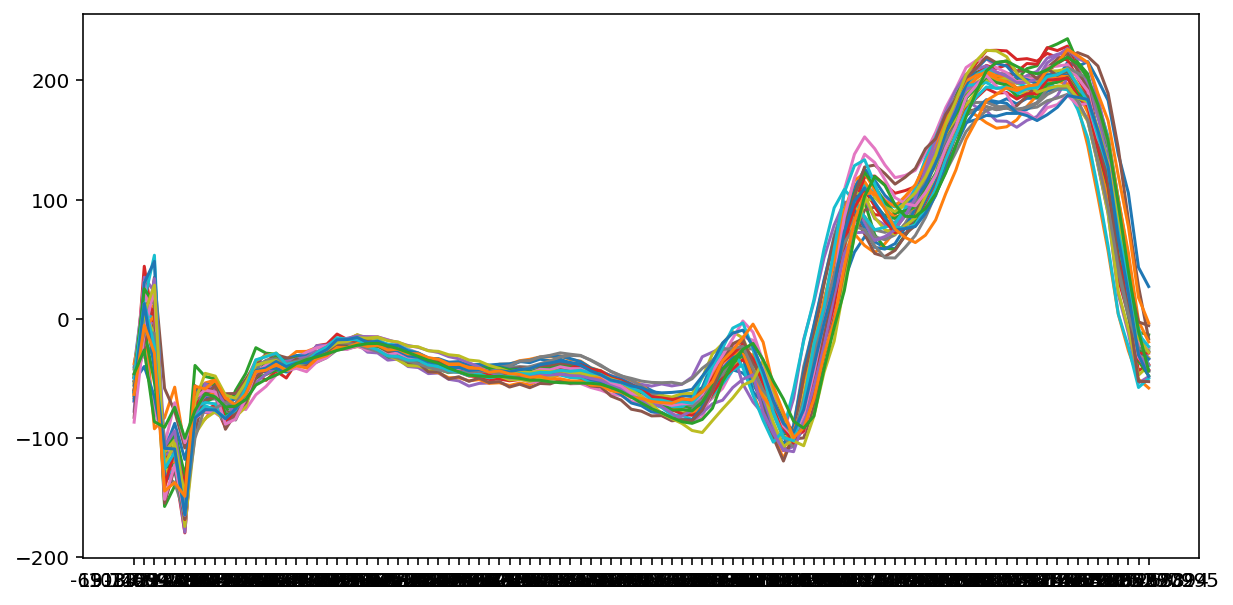

In [17]:
plt.figure(figsize=(10,5))
for i in range(len(plot_data)):
    plt.plot(plot_data.iloc[i, 0::])